In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import zipfile
from PIL import Image
from io import BytesIO
import shutil
import shutil
from tqdm import tqdm
import torch
from torchvision import models
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
import random
from sklearn.metrics import accuracy_score
from scipy.stats import entropy

# Carichiamo i dati

In [ ]:
import os
import pandas as pd
from tqdm.notebook import tqdm

csv_file = '/kaggle/input/label-train/train_small.csv'  # Percorso del file CSV
images_dir = '/kaggle/input/data-label/solo_train'  # Percorso della cartella immagini

df_labels = pd.read_csv(csv_file, header=None, names=['filename', 'label'])

labeled_dataset = []

for _, row in tqdm(df_labels.iterrows(), total=len(df_labels), desc="Matching images"):
    image_file = row['filename']
    label = row['label']
    image_path = os.path.join(images_dir, image_file)

    if os.path.exists(image_path):
        labeled_dataset.append((image_path, label))

print(f"Numero di immagini matchate: {len(labeled_dataset)}")

Matching images:   0%|          | 0/5020 [00:00<?, ?it/s]

Numero di immagini matchate: 5020


## Carichiamo la Rete

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation

def custom_layer_wrapper(layer_class):
    def wrapper(*args, **kwargs):
        if 'name' in kwargs:
            kwargs['name'] = kwargs['name'].replace('/', '_')  
        return layer_class(*args, **kwargs)
    return wrapper

custom_conv2d = custom_layer_wrapper(Conv2D)
custom_batch_norm = custom_layer_wrapper(BatchNormalization)
custom_activation = custom_layer_wrapper(Activation)

model_path = '/kaggle/input/densenet32/other/default/1/RESNET_Kaggle.hdf5'

resnet_kaggle_model = tf.keras.models.load_model(
    model_path,
    custom_objects={
        'Conv2D': custom_conv2d,
        'BatchNormalization': custom_batch_norm,
        'Activation': custom_activation
    }
)

# Processiamo le immagini 64x64

In [ ]:
import numpy as np
from PIL import Image

def preprocess_image(img_path, target_size=(64,64)):
    img = Image.open(img_path).convert("RGB")  # Converte in RGB
    img = img.resize(target_size)  # Ridimensiona l'immagine
    img_array = np.array(img) / 255.0  # Normalizza i pixel tra [0, 1]
    img_array = np.expand_dims(img_array, axis=0)  # Aggiungi la dimensione batch
    return img_array

# labeled_dataset contiene (image_path, label)
images_to_train = [img[0] for img in labeled_dataset]  # Estrae i percorsi delle immagini
true_labels = [label for _, label in labeled_dataset]  # Estrae le label corrispondenti

processed_images = np.vstack([preprocess_image(img) for img in images_to_train])

true_labels = np.array(true_labels)

print(f"Numero di immagini preprocessate: {processed_images.shape[0]}")
print(f"Shape di ogni immagine: {processed_images.shape[1:]}")
print(f"Numero di label: {true_labels.shape[0]}")

Numero di immagini preprocessate: 5020
Shape di ogni immagine: (64, 64, 3)
Numero di label: 5020


# Tagliamo la rete

📌 Struttura:
- Caricamento DenseNet201 pre-addestrato
- Congelamento pesi del modello base
- Aggiunta di un nuovo Fully Connected Network: 512 → 256 → 128 neuroni, ciascuno con: ReLU
- Batch Normalization
- Dropout più elevato (50%, 40%)

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Resizing, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# === 1. Definiamo il nuovo input layer per immagini 64×64×3 ===
input_layer = Input(shape=(64, 64, 3))

# === 2. Aggiungiamo un layer di ridimensionamento a 224×224 ===
resized_input = Resizing(224, 224)(input_layer)

# === 3. Congeliamo i pesi del modello preaddestrato ===
resnet_kaggle_model.trainable = False

# === 4. Modello intermedio utilizzando l'output del layer globale di pooling ===
output_layer = resnet_kaggle_model.get_layer("global_average_pooling2d").output
intermediate_model = Model(inputs=resnet_kaggle_model.input, outputs=output_layer)

# === 5. Applichiamo l'input ridimensionato al modello intermedio ===
x = intermediate_model(resized_input)

# === 6. Aggiungiamo i layer fully connected ===
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

# Layer finale con 251 classi, attivazione softmax
output = Dense(251, activation='softmax')(x)

# === 7. Compilazione del modello ===
final_model = Model(inputs=input_layer, outputs=output)
optimizer = Adam(learning_rate=0.001)
final_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
final_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resizing (Resizing)                  │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional (Functional)              │ (None, 1920)                │      18,321,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         983,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 251)                 │          32,379 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,505,723 (74.41 MB)

 Trainable params: 1,181,947 (4.51 MB)

 Non-trainable params: 18,323,776 (69.90 MB)

Alleniamo il modello

In [10]:
history1 = final_model.fit(
    processed_images,
    true_labels,
    epochs=50,
    batch_size=128,
    verbose=1
)

Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 92s 862ms/step - accuracy: 0.0039 - loss: 5.9475
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 228ms/step - accuracy: 0.0334 - loss: 5.1963
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 228ms/step - accuracy: 0.0951 - loss: 4.7265
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 229ms/step - accuracy: 0.1732 - loss: 4.2541
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 228ms/step - accuracy: 0.2207 - loss: 3.9363
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 228ms/step - accuracy: 0.2762 - loss: 3.6086
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 228ms/step - accuracy: 0.3005 - loss: 3.3452
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 228ms/step - accuracy: 0.3511 - loss: 3.1444
Epoch 9/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 229ms/step - accuracy: 0.3717 - loss: 2.9302
Epoch 10/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 229ms/step - accuracy: 0.4038 - loss: 2.7632
Epoch 11/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 229ms/step - accuracy: 0.4158 - loss: 2.6302
Epoch 12/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 228ms/ste

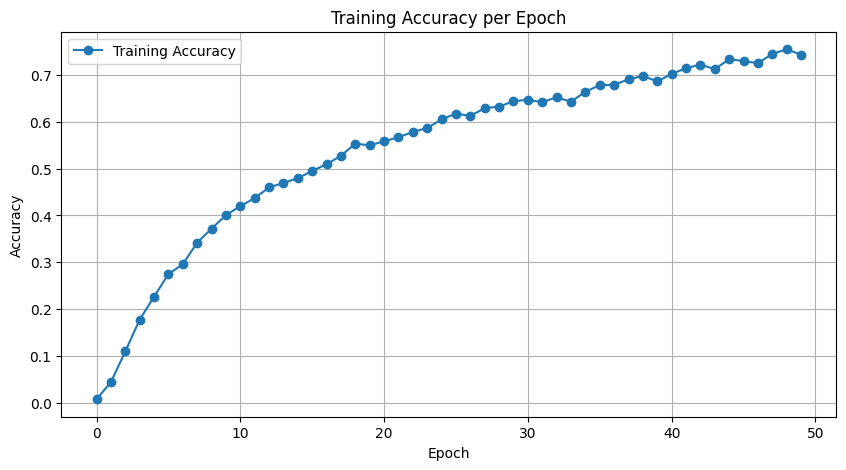

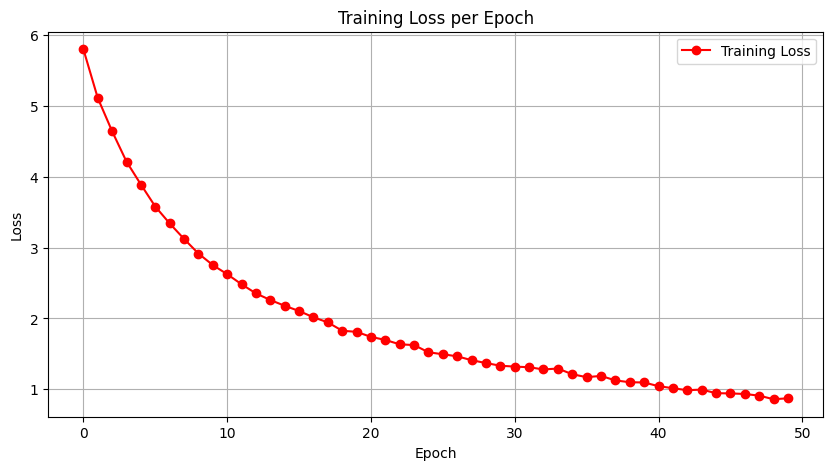

In [ ]:
# === 1. Estraiamo le metriche dal training history ===
accuracy = history1.history['accuracy']
loss = history1.history['loss']

# === 2. Plottiamo l'accuracy ===
plt.figure(figsize=(10, 5))
plt.plot(accuracy, label='Training Accuracy', marker='o')
plt.title('Training Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# === 3. Plottiamo la loss ===
plt.figure(figsize=(10, 5))
plt.plot(loss, label='Training Loss', marker='o', color='red')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Vediamo il validation

In [ ]:
import os
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from PIL import Image
from sklearn.metrics import accuracy_score

# === 1. Funzione per abbinare immagini e label ===
def match_images_and_labels(csv_file, images_dir):
    df_labels = pd.read_csv(csv_file, header=None, names=['filename', 'label'])
    matched_dataset = []
    
    for _, row in tqdm(df_labels.iterrows(), total=len(df_labels), desc="Matching images"):
        image_file = row['filename']
        label = row['label']
        image_path = os.path.join(images_dir, image_file)

        if os.path.exists(image_path):
            matched_dataset.append((image_path, label))

    print(f"Numero di immagini matchate: {len(matched_dataset)}")
    return matched_dataset

# === 2. Funzione per preprocessare un'immagine ===
def preprocess_image(img_path, target_size=(64,64)):
    img = Image.open(img_path).convert("RGB")
    img = img.resize(target_size)
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Aggiungi la dimensione batch
    return img_array

validation_csv_file = '/kaggle/input/validation-label/val_info.csv'
validation_images_dir = '/kaggle/input/validation-set/val_set'

validation_dataset = match_images_and_labels(validation_csv_file, validation_images_dir)

validation_degraded_images_dir = '/kaggle/input/validation-degreded/val_set_degraded'

validation_degraded_dataset = match_images_and_labels(validation_csv_file, validation_degraded_images_dir)

validation_images = [img[0] for img in validation_dataset]
validation_labels = [label for _, label in validation_dataset]

validation_degraded_images = [img[0] for img in validation_degraded_dataset]
validation_degraded_labels = [label for _, label in validation_degraded_dataset]

processed_validation_images = np.vstack([
    preprocess_image(img) for img in tqdm(validation_images, desc="Preprocessing original validation images", total=len(validation_images))
])

processed_validation_degraded_images = np.vstack([
    preprocess_image(img) for img in tqdm(validation_degraded_images, desc="Preprocessing degraded validation images", total=len(validation_degraded_images))
])

validation_labels = np.array(validation_labels)
validation_degraded_labels = np.array(validation_degraded_labels)

predictions_validation = np.vstack([
    final_model.predict(processed_validation_images[i:i+32], verbose=0) 
    for i in tqdm(range(0, len(processed_validation_images), 32), desc="Predicting original validation batches")
])

predictions_degraded = np.vstack([
    final_model.predict(processed_validation_degraded_images[i:i+32], verbose=0) 
    for i in tqdm(range(0, len(processed_validation_degraded_images), 32), desc="Predicting degraded validation batches")
])

predicted_classes_validation = np.argmax(predictions_validation, axis=1)
predicted_classes_degraded = np.argmax(predictions_degraded, axis=1)

accuracy_validation = accuracy_score(validation_labels, predicted_classes_validation)
accuracy_degraded = accuracy_score(validation_degraded_labels, predicted_classes_degraded)

print(f"Accuracy sul dataset ORIGINALE: {accuracy_validation * 100:.2f}%")
print(f"Accuracy sul dataset DEGRADATO: {accuracy_degraded * 100:.2f}%")

Matching images:   0%|          | 0/11994 [00:00<?, ?it/s]

Numero di immagini matchate: 11994


Matching images:   0%|          | 0/11994 [00:00<?, ?it/s]

Numero di immagini matchate: 11994


Preprocessing original validation images:   0%|          | 0/11994 [00:00<?, ?it/s]

Preprocessing degraded validation images:   0%|          | 0/11994 [00:00<?, ?it/s]

Predicting original validation batches:   0%|          | 0/375 [00:00<?, ?it/s]

Predicting degraded validation batches:   0%|          | 0/375 [00:00<?, ?it/s]

Accuracy sul dataset ORIGINALE: 41.73%
Accuracy sul dataset DEGRADATO: 32.62%


# Vediamo i livelli di confidenza della classificazione

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import entropy
from tqdm.notebook import tqdm

predictions = np.vstack([
    final_model.predict(processed_sampled_images[i:i+32], verbose=0)
    for i in tqdm(range(0, len(processed_sampled_images), 32), desc="Predicting batches")
])

predicted_classes = np.argmax(predictions, axis=1)
confidences = np.max(predictions, axis=1)  # Confidenza basata su max softmax

entropies = entropy(predictions.T)  # Entropia per ogni immagine

#  DataFrame dei risultati
results_df = pd.DataFrame({
    'Percorso Immagine': sampled_images,  # il percorso dell'immagine
    'Classe Predetta': predicted_classes,
    'Label Reale': sampled_labels,
    'Confidenza (Max Softmax)': confidences,
    'Entropia (Incertezza)': entropies
})

Predicting batches:   0%|          | 0/375 [00:00<?, ?it/s]

In [19]:
results_df.head(3)

,Percorso Immagine,Classe Predetta,Label Reale,Confidenza (Max Softmax),Entropia (Incertezza)
0,/kaggle/input/validation-set/val_set/val_00878...,52,0,0.541861,1.788228
1,/kaggle/input/validation-set/val_set/val_00001...,132,54,0.347907,1.857761
2,/kaggle/input/validation-set/val_set/val_01074...,214,214,0.806998,1.053259


## Vediamo con quanta confidenza predice correttamente

In [20]:
df_esatti = results_df[results_df['Classe Predetta'] == results_df['Label Reale']]
df_esatti.head(3)

,Percorso Immagine,Classe Predetta,Label Reale,Confidenza (Max Softmax),Entropia (Incertezza)
2,/kaggle/input/validation-set/val_set/val_01074...,214,214,0.806998,1.053259
3,/kaggle/input/validation-set/val_set/val_00273...,160,160,0.999645,0.003567
5,/kaggle/input/validation-set/val_set/val_00187...,204,204,0.999660,0.003444


In [21]:
df_esatti.shape

(5005, 5)

In [22]:
df_esatti['Confidenza (Max Softmax)'].describe()

count    5005.000000
mean        0.821169
std         0.216992
min         0.097971
25%         0.687079
50%         0.931176
75%         0.993815
max         1.000000
Name: Confidenza (Max Softmax), dtype: float64

In [23]:
df_esatti['Entropia (Incertezza)'].describe()

count    5005.000000
mean        0.639175
std         0.729717
min         0.000002
25%         0.046845
50%         0.347720
75%         1.028406
max         3.636537
Name: Entropia (Incertezza), dtype: float64

## Vediamo con quanta confidenza sbaglia

In [24]:
df_sbagliati= results_df[results_df['Classe Predetta'] != results_df['Label Reale']]
df_sbagliati.head(3)

,Percorso Immagine,Classe Predetta,Label Reale,Confidenza (Max Softmax),Entropia (Incertezza)
0,/kaggle/input/validation-set/val_set/val_00878...,52,0,0.541861,1.788228
1,/kaggle/input/validation-set/val_set/val_00001...,132,54,0.347907,1.857761
4,/kaggle/input/validation-set/val_set/val_00223...,58,55,0.606557,1.830194


In [25]:
df_sbagliati.shape

(6988, 5)

6366 predizioni sbagliate e 2634 giuste

In [26]:
df_sbagliati['Confidenza (Max Softmax)'].describe()

count    6988.000000
mean        0.543243
std         0.244483
min         0.069891
25%         0.341122
50%         0.514860
75%         0.739312
max         0.999981
Name: Confidenza (Max Softmax), dtype: float64

In [27]:
df_sbagliati['Entropia (Incertezza)'].describe()

count    6988.000000
mean        1.614793
std         0.888467
min         0.000253
25%         0.921551
50%         1.573809
75%         2.274951
max         4.082355
Name: Entropia (Incertezza), dtype: float64

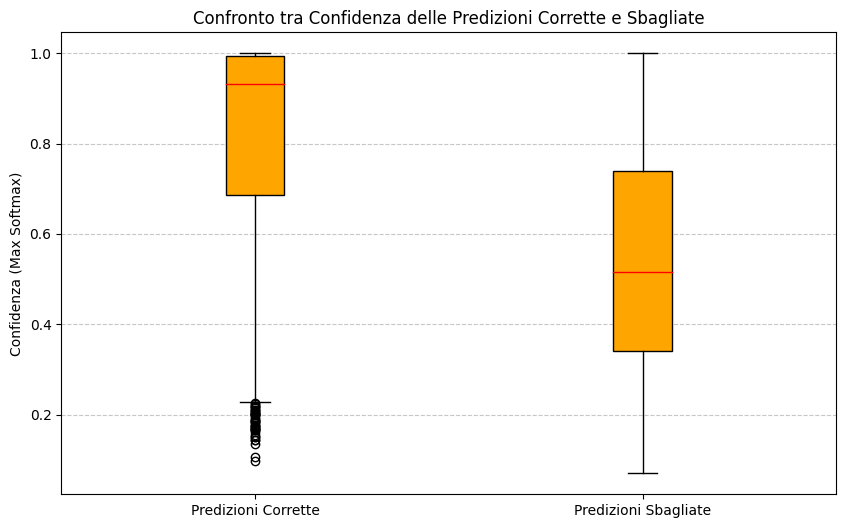

In [28]:
# Boxplot dei due gruppi affiancati
plt.figure(figsize=(10, 6))
plt.boxplot(
    [df_esatti['Confidenza (Max Softmax)'], df_sbagliati['Confidenza (Max Softmax)']], 
    labels=['Predizioni Corrette', 'Predizioni Sbagliate'],
    patch_artist=True,
    boxprops=dict(facecolor='orange', color='black'),  # Colore del box
    medianprops=dict(color='red')  # Colore della mediana
)

# Titoli e etichette
plt.title('Confronto tra Confidenza delle Predizioni Corrette e Sbagliate')
plt.ylabel('Confidenza (Max Softmax)')
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Aggiunge la griglia solo sull'asse y
plt.show()


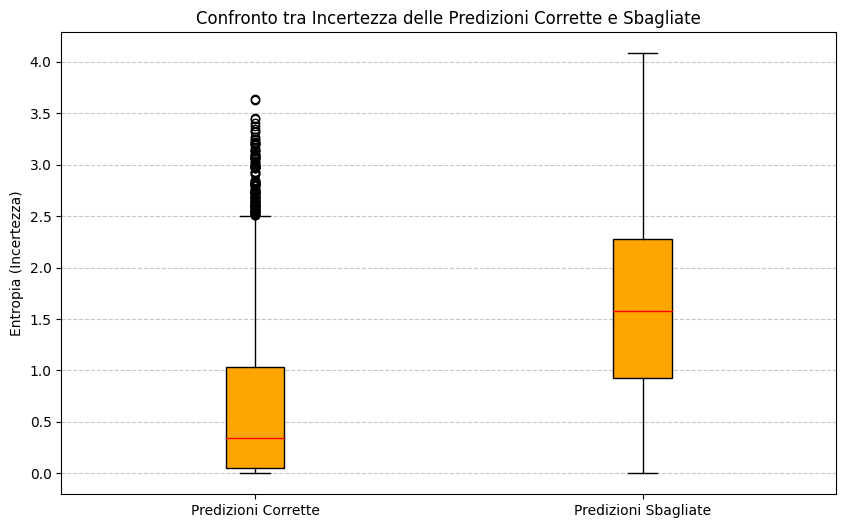

In [29]:
# Boxplot dei due gruppi affiancati
plt.figure(figsize=(10, 6))
plt.boxplot(
    [df_esatti['Entropia (Incertezza)'], df_sbagliati['Entropia (Incertezza)']], 
    labels=['Predizioni Corrette', 'Predizioni Sbagliate'],
    patch_artist=True,
    boxprops=dict(facecolor='orange', color='black'),  # Colore del box
    medianprops=dict(color='red')  # Colore della mediana
)

# Titoli e etichette
plt.title('Confronto tra Incertezza delle Predizioni Corrette e Sbagliate')
plt.ylabel('Entropia (Incertezza)')
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Aggiunge la griglia solo sull'asse y
plt.show()

Andiamo a decidere i valori di treshold:

stampiamo 5 immagini casuali con confidenza sopra il terzo percentile e affianco gli stampiamo immagini diverse della stessa label, poi lo facciamo anche con le predizioni sbagliate

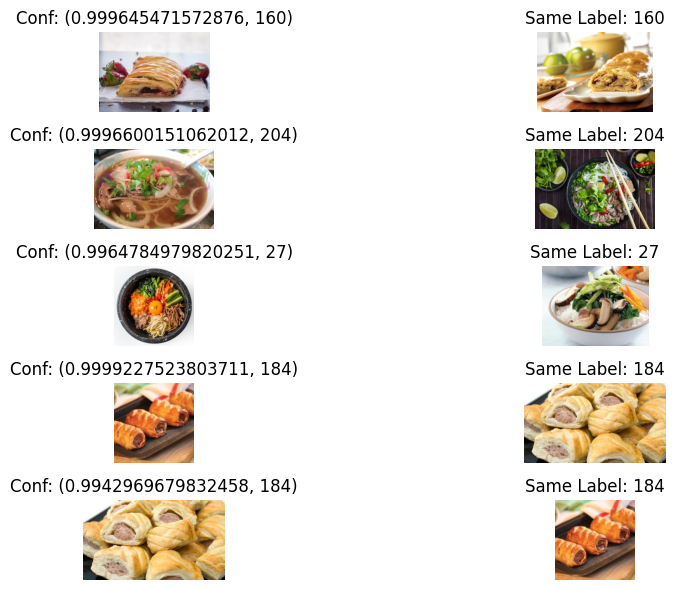

In [ ]:
# Filtra il DataFrame per ottenere immagini con confidenza > 0.977185 per le predizioni corrette
filtered_df = df_esatti[df_esatti['Confidenza (Max Softmax)'] > 0.977185]

# Funzione per trovare un'immagine con la stessa label reale diversa dall'immagine originale
def find_same_label_image(df, current_image, label):
    candidates = df[(df['Label Reale'] == label) & (df['Percorso Immagine'] != current_image)]
    if not candidates.empty:
        return candidates.iloc[0]['Percorso Immagine']  # Ritorna il percorso della prima immagine trovata
    return None 

# Mostra coppie di immagini
plt.figure(figsize=(12, 6))
num_display = min(5, len(filtered_df))  # Mostra solo le prime 5 coppie

for plot_idx, (idx, row) in enumerate(filtered_df.head(num_display).iterrows()):
    img1_path = row['Percorso Immagine']
    img2_path = find_same_label_image(results_df, img1_path, row['Label Reale'])
    
    # Se troviamo un'immagine con la stessa label reale, mostra la coppia
    if img2_path and os.path.exists(img1_path) and os.path.exists(img2_path):
        img1 = Image.open(img1_path)
        img2 = Image.open(img2_path)
        
        # Crea i subplot per mostrare le immagini affiancate
        plt.subplot(num_display, 2, plot_idx * 2 + 1)
        plt.imshow(img1)
        plt.axis('off')
        plt.title(f"Conf: {row['Confidenza (Max Softmax)'], row['Classe Predetta']}")

        plt.subplot(num_display, 2, plot_idx * 2 + 2)
        plt.imshow(img2)
        plt.axis('off')
        plt.title(f"Same Label: {row['Label Reale']}")
        
plt.tight_layout()
plt.show()

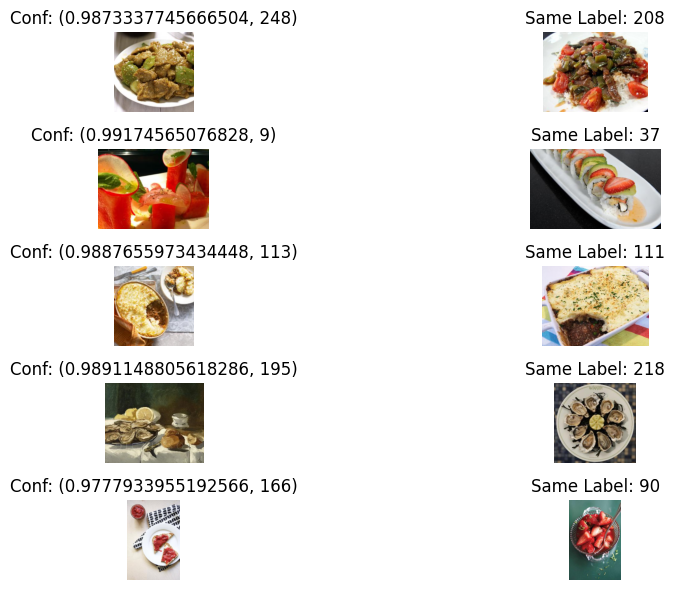

In [ ]:
# Filtra il DataFrame per ottenere immagini con confidenza > 0.977185 per le predizioni errate
filtered_df = df_sbagliati[df_sbagliati['Confidenza (Max Softmax)'] > 0.977185]

def find_same_label_image(df, current_image, label):
    candidates = df[(df['Label Reale'] == label) & (df['Percorso Immagine'] != current_image)]
    if not candidates.empty:
        return candidates.iloc[0]['Percorso Immagine'] 
    return None 

# Mostra coppie di immagini
plt.figure(figsize=(12, 6))
num_display = min(5, len(filtered_df))  # Mostra solo le prime 5 coppie

for plot_idx, (idx, row) in enumerate(filtered_df.head(num_display).iterrows()):
    img1_path = row['Percorso Immagine']
    img2_path = find_same_label_image(results_df, img1_path, row['Label Reale'])
    
    if img2_path and os.path.exists(img1_path) and os.path.exists(img2_path):
        img1 = Image.open(img1_path)
        img2 = Image.open(img2_path)

        plt.subplot(num_display, 2, plot_idx * 2 + 1)
        plt.imshow(img1)
        plt.axis('off')
        plt.title(f"Conf: {row['Confidenza (Max Softmax)'], row['Classe Predetta']}")

        plt.subplot(num_display, 2, plot_idx * 2 + 2)
        plt.imshow(img2)
        plt.axis('off')
        plt.title(f"Same Label: {row['Label Reale']}")
        
plt.tight_layout()
plt.show()

facciamo la stessa cosa con l'entropia minore del primo quartile per quelle classificate bene

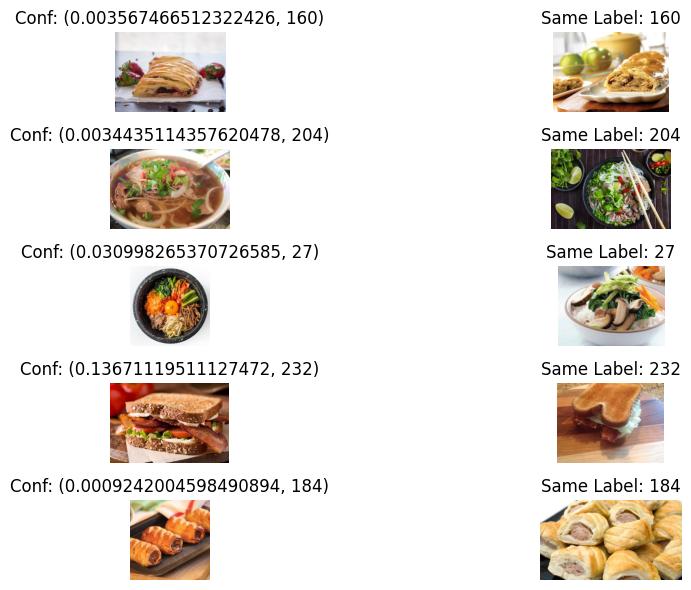

In [ ]:
filtered_df = df_esatti[df_esatti['Entropia (Incertezza)'] < 0.141016]

def find_same_label_image(df, current_image, label):
    candidates = df[(df['Label Reale'] == label) & (df['Percorso Immagine'] != current_image)]
    if not candidates.empty:
        return candidates.iloc[0]['Percorso Immagine']  # Ritorna il percorso della prima immagine trovata
    return None 

# Mostra coppie di immagini
plt.figure(figsize=(12, 6))
num_display = min(5, len(filtered_df))  # Mostra solo le prime 5 coppie

for plot_idx, (idx, row) in enumerate(filtered_df.head(num_display).iterrows()):
    img1_path = row['Percorso Immagine']
    img2_path = find_same_label_image(results_df, img1_path, row['Label Reale'])
    if img2_path and os.path.exists(img1_path) and os.path.exists(img2_path):
        img1 = Image.open(img1_path)
        img2 = Image.open(img2_path)
        
        plt.subplot(num_display, 2, plot_idx * 2 + 1)
        plt.imshow(img1)
        plt.axis('off')
        plt.title(f"Conf: {row['Entropia (Incertezza)'], row['Classe Predetta']}")

        plt.subplot(num_display, 2, plot_idx * 2 + 2)
        plt.imshow(img2)
        plt.axis('off')
        plt.title(f"Same Label: {row['Label Reale']}")
        
plt.tight_layout()
plt.show()

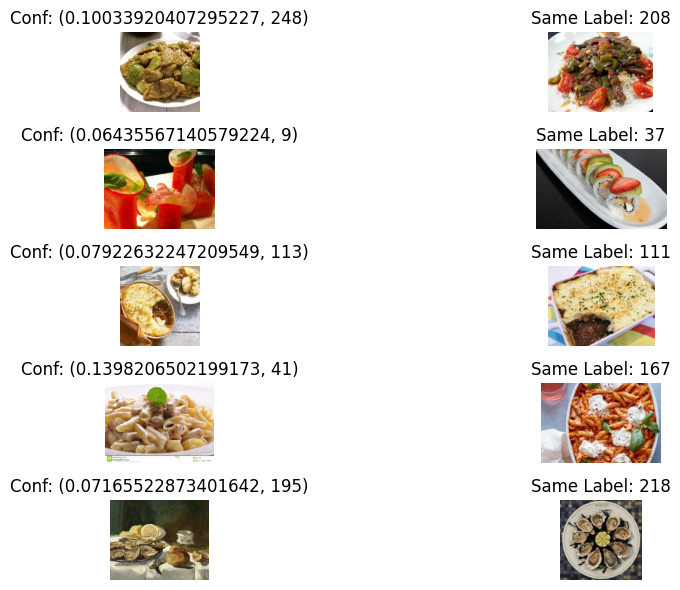

In [ ]:
# stessa cosa ma con le predizioni sbagliate
filtered_df = df_sbagliati[df_sbagliati['Entropia (Incertezza)'] < 0.141016]

def find_same_label_image(df, current_image, label):
    candidates = df[(df['Label Reale'] == label) & (df['Percorso Immagine'] != current_image)]
    if not candidates.empty:
        return candidates.iloc[0]['Percorso Immagine']  # Ritorna il percorso della prima immagine trovata
    return None 

plt.figure(figsize=(12, 6))
num_display = min(5, len(filtered_df))  # Mostra solo le prime 5 coppie

for plot_idx, (idx, row) in enumerate(filtered_df.head(num_display).iterrows()):
    img1_path = row['Percorso Immagine']
    img2_path = find_same_label_image(results_df, img1_path, row['Label Reale'])
    
    if img2_path and os.path.exists(img1_path) and os.path.exists(img2_path):
        img1 = Image.open(img1_path)
        img2 = Image.open(img2_path)
        
        plt.subplot(num_display, 2, plot_idx * 2 + 1)
        plt.imshow(img1)
        plt.axis('off')
        plt.title(f"Conf: {row['Entropia (Incertezza)'], row['Classe Predetta']}")

        plt.subplot(num_display, 2, plot_idx * 2 + 2)
        plt.imshow(img2)
        plt.axis('off')
        plt.title(f"Same Label: {row['Label Reale']}")
        
plt.tight_layout()
plt.show()

## Proviamo su unlabeled set

In [ ]:
images_dir = '/kaggle/input/unlabel/unlabel_processed'

unlabeled_dataset = []

# Cicla su tutti i file nella cartella immagini
for image_file in tqdm(os.listdir(images_dir), desc="Loading images"):
    image_path = os.path.join(images_dir, image_file)

    # Verifica se è un file immagine
    if os.path.isfile(image_path) and image_file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
        unlabeled_dataset.append(image_path)

Loading images:   0%|          | 0/113455 [00:00<?, ?it/s]

Dimensioni immagine: 224x224 (larghezza x altezza)


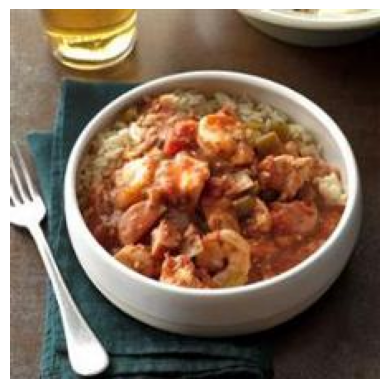

In [ ]:
image_path = unlabeled_dataset[0]
image = Image.open(image_path)

width, height = image.size
print(f"Dimensioni immagine: {width}x{height} (larghezza x altezza)")

# Mostra l'immagine
plt.imshow(image)
plt.axis('off')  # Rimuove gli assi
plt.show()

Proviamo a vedere come classifica le immagini nell'unlabel-set

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import entropy
from tqdm import tqdm
from PIL import Image
import gc  # Per liberare la memoria

# === Funzione per il preprocessing delle immagini ===
def load_and_preprocess_images(image_paths, target_size=(64, 64)):
    images = []
    for path in tqdm(image_paths, desc="Preprocessing images"):
        image = Image.open(path).convert('RGB')  # Converte in RGB
        image = image.resize(target_size)  # Resize all'immagine desiderata
        image = np.array(image) / 255.0  # Normalizza tra 0 e 1
        images.append(image)
    return np.array(images)

# === Funzione per generare il DataFrame delle predizioni ===
def generate_predictions_df(final_model, image_paths, batch_size=32):
    # Preprocessa le immagini
    processed_images = load_and_preprocess_images(image_paths)
    
    # === 1. Effettua le predizioni batch ===
    predictions = np.vstack([
        final_model.predict(processed_images[i:i + batch_size], verbose=0)
        for i in tqdm(range(0, len(processed_images), batch_size), desc="Predicting batches")
    ])

    # === 2. Calcola le top 3 classi predette e le rispettive confidences ===
    top_3_indices = np.argsort(predictions, axis=1)[:, -3:][:, ::-1]  # Ottieni gli indici delle top 3 classi
    top_3_confidences = np.sort(predictions, axis=1)[:, -3:][:, ::-1]  # Ottieni le top 3 confidences

    # Separazione delle top 3 per costruire il DataFrame
    predicted_class_1 = top_3_indices[:, 0]
    predicted_class_2 = top_3_indices[:, 1]
    predicted_class_3 = top_3_indices[:, 2]

    confidence_top_1 = top_3_confidences[:, 0]
    confidence_top_2 = top_3_confidences[:, 1]
    confidence_top_3 = top_3_confidences[:, 2]

    # === 3. Calcola l'entropia per ogni immagine ===
    entropies = entropy(predictions.T)

    results_df = pd.DataFrame({
        'Percorso Immagine': image_paths,
        'Classe Predetta 1': predicted_class_1,
        'Confidenza Top 1': confidence_top_1,
        'Classe Predetta 2': predicted_class_2,
        'Confidenza Top 2': confidence_top_2,
        'Classe Predetta 3': predicted_class_3,
        'Confidenza Top 3': confidence_top_3,
        'Entropia (Incertezza)': entropies
    })

    return results_df

In [ ]:
n_chunks = 30
chunk_size = len(unlabeled_dataset) // n_chunks

datasets = [unlabeled_dataset[i:i + chunk_size] for i in range(0, len(unlabeled_dataset), chunk_size)]

if len(unlabeled_dataset) % n_chunks != 0:
    datasets[-1].extend(unlabeled_dataset[n_chunks * chunk_size:])

for idx, dataset in enumerate(datasets):
    globals()[f'un_{str(idx+1).zfill(2)}'] = dataset

l = [globals()[f'un_{str(i).zfill(2)}'] for i in range(1, 21)]

In [ ]:
final_results_df = pd.DataFrame()

for minidataset in l:
    print("Elaborazione di un nuovo minidataset...")

    image_paths = minidataset

    results_df = generate_predictions_df(final_model, image_paths)

    final_results_df = pd.concat([final_results_df, results_df], ignore_index=True)

    # === Elimina le variabili temporanee per liberare la memoria ===
    del results_df
    gc.collect() 

In [49]:
# Visualizza i primi risultati
final_results_df.head(1)

,Percorso Immagine,Classe Predetta 1,Confidenza Top 1,Classe Predetta 2,Confidenza Top 2,Classe Predetta 3,Confidenza Top 3,Entropia (Incertezza)
0,/kaggle/input/unlabel/unlabel_processed/image_...,154,0.992623,66,0.002634,117,0.00102,0.058797


In [50]:
final_results_df.sort_values(by='Entropia (Incertezza)', ascending=True).head()

,Percorso Immagine,Classe Predetta 1,Confidenza Top 1,Classe Predetta 2,Confidenza Top 2,Classe Predetta 3,Confidenza Top 3,Entropia (Incertezza)
44650,/kaggle/input/unlabel/unlabel_processed/image_...,49,1.0,138,7.040793e-08,124,1.738051e-08,0.000002
29188,/kaggle/input/unlabel/unlabel_processed/image_...,49,1.0,138,7.749779e-08,124,3.840577e-08,0.000002
17882,/kaggle/input/unlabel/unlabel_processed/image_...,0,1.0,116,3.037834e-08,156,1.582592e-08,0.000003
10848,/kaggle/input/unlabel/unlabel_processed/image_...,49,1.0,138,1.168412e-07,124,7.204516e-08,0.000003
12846,/kaggle/input/unlabel/unlabel_processed/image_...,131,1.0,240,1.747806e-07,206,1.855652e-08,0.000004


Teniamo le immagini con il valore più alto

In [51]:
lista_soglie = [0.97]
val_soglia = (0.97)
upper = (1-val_soglia)/20
for soglie in range(0,19):
    val_soglia += upper
    lista_soglie.append(val_soglia)

In [52]:
es = len(df_esatti)
sb = len(df_sbagliati)

In [53]:
lista_valori_esatti= []
for soglia in lista_soglie:
    num = len(df_esatti[df_esatti['Confidenza (Max Softmax)']>=soglia])
    val = (num/es)*100
    lista_valori_esatti.append(val)

In [54]:
lista_valori_sbagliati= []
for soglia in lista_soglie:
    num = len(df_sbagliati[df_sbagliati['Confidenza (Max Softmax)']>=soglia])
    val = (num/sb)*100
    lista_valori_sbagliati.append(val)

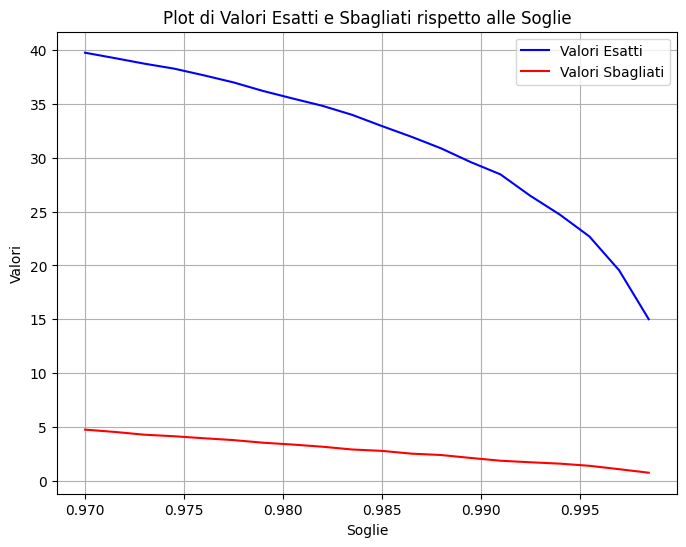

In [55]:
# Creazione del plot
plt.figure(figsize=(8, 6))
plt.plot(lista_soglie, lista_valori_esatti, label='Valori Esatti', color='blue')
plt.plot(lista_soglie, lista_valori_sbagliati, label='Valori Sbagliati', color='red', linestyle='-')

# Aggiunta delle etichette e titolo
plt.xlabel('Soglie')
plt.ylabel('Valori')
plt.title('Plot di Valori Esatti e Sbagliati rispetto alle Soglie')
plt.legend()
plt.grid(True)
plt.show()

Text(0.5, 1.0, 'Differenze')

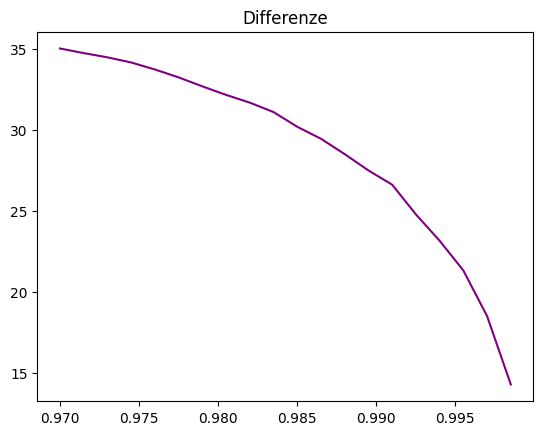

In [56]:
lista_differenza = []
for i in range(0,len(lista_soglie)):
    val = lista_valori_esatti[i] - lista_valori_sbagliati[i]
    lista_differenza.append(val)
plt.plot(lista_soglie, lista_differenza, color='purple')
plt.title('Differenze')

Text(0.5, 1.0, 'Differenze')

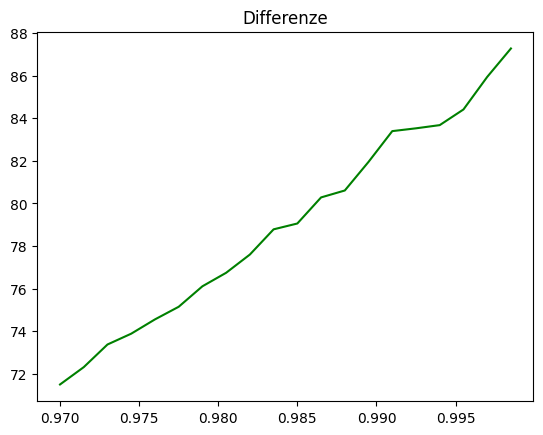

In [57]:
lista_diff = []
for i in range(0,len(lista_soglie)):
    a = len(df_sbagliati[df_sbagliati['Confidenza (Max Softmax)']>=lista_soglie[i]])
    b = len(df_esatti[df_esatti['Confidenza (Max Softmax)']>=lista_soglie[i]])
    c = ((b-a)/(a+b))*100
    lista_diff.append(c)
plt.plot(lista_soglie, lista_diff, color='green')
plt.title('Differenze')

In [58]:
final_results_df[final_results_df['Confidenza Top 1']>=(0.99)].shape

(9371, 8)

# Classificazione sul dataset senza outlier

In [ ]:
import os
import pandas as pd
from tqdm.notebook import tqdm

csv_file = '/kaggle/input/labale-del-train/train_small.csv'  # Percorso del file CSV
images_dir = '/kaggle/input/dataset-tain/solo_train'  # Percorso della cartella immagini

df_labels = pd.read_csv(csv_file, header=None, names=['filename', 'label'])

labeled_dataset = []

for _, row in tqdm(df_labels.iterrows(), total=len(df_labels), desc="Matching images"):
    image_file = row['filename']
    label = row['label']
    image_path = os.path.join(images_dir, image_file)

    if os.path.exists(image_path):
        labeled_dataset.append((image_path, label))

print(f"Numero di immagini matchate: {len(labeled_dataset)}")

Matching images:   0%|          | 0/5020 [00:00<?, ?it/s]

Numero di immagini matchate: 5020


Eliminiamo gli outlier

In [ ]:
outliers_csv = '/kaggle/input/outliers-da-rimuovere/outliers_to_delete.csv'
outliers_df = pd.read_csv(outliers_csv, header=None, names=['filename'])

outliers_to_delete = set(outliers_df['filename'].tolist())

filtered_labeled_dataset = [
    (img_path, label) for img_path, label in labeled_dataset 
    if os.path.basename(img_path) not in outliers_to_delete
]

print(f"Numero di immagini rimanenti dopo il filtro: {len(filtered_labeled_dataset)}")

Numero di immagini rimanenti dopo il filtro: 4921


## Caricamento e taglio rete 

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation

def custom_layer_wrapper(layer_class):
    def wrapper(*args, **kwargs):
        if 'name' in kwargs:
            kwargs['name'] = kwargs['name'].replace('/', '_')  # Sostituisce "/" con "_"
        return layer_class(*args, **kwargs)
    return wrapper

custom_conv2d = custom_layer_wrapper(Conv2D)
custom_batch_norm = custom_layer_wrapper(BatchNormalization)
custom_activation = custom_layer_wrapper(Activation)

model_path = '/kaggle/input/model_kaggle/other/default/1/RESNET_Kaggle.hdf5'

resnet_kaggle_model = tf.keras.models.load_model(
    model_path,
    custom_objects={
        'Conv2D': custom_conv2d,
        'BatchNormalization': custom_batch_norm,
        'Activation': custom_activation
    }
)

In [ ]:
# Funzione per preprocessare un'immagine
def preprocess_image(img_path, target_size=(64,64)):
    img = Image.open(img_path).convert("RGB")  # Converte in RGB
    img = img.resize(target_size)  # Ridimensiona l'immagine
    img_array = np.array(img) / 255.0  # Normalizza i pixel tra [0, 1]
    img_array = np.expand_dims(img_array, axis=0)  # Aggiungi la dimensione batch
    return img_array

images_to_train = [img[0] for img in filtered_labeled_dataset]  # Estrae i percorsi delle immagini
true_labels = [label for _, label in filtered_labeled_dataset]  # Estrae le label corrispondenti

processed_images = np.vstack([preprocess_image(img) for img in images_to_train])

true_labels = np.array(true_labels)

print(f"Numero di immagini preprocessate: {processed_images.shape[0]}")
print(f"Shape di ogni immagine: {processed_images.shape[1:]}")
print(f"Numero di label: {true_labels.shape[0]}")

Numero di immagini preprocessate: 4921
Shape di ogni immagine: (64, 64, 3)
Numero di label: 4921


In [ ]:
import os
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from PIL import Image
from sklearn.metrics import accuracy_score

def match_images_and_labels(csv_file, images_dir):
    df_labels = pd.read_csv(csv_file, header=None, names=['filename', 'label'])
    matched_dataset = []
    
    for _, row in tqdm(df_labels.iterrows(), total=len(df_labels), desc="Matching images"):
        image_file = row['filename']
        label = row['label']
        image_path = os.path.join(images_dir, image_file)

        if os.path.exists(image_path):
            matched_dataset.append((image_path, label))

    print(f"Numero di immagini matchate: {len(matched_dataset)}")
    return matched_dataset

def preprocess_image(img_path, target_size=(64,64)):
    img = Image.open(img_path).convert("RGB")
    img = img.resize(target_size)
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Aggiungi la dimensione batch
    return img_array

# === Caricamento del dataset ORIGINALE ===
validation_csv_file = '/kaggle/input/label-validation/val_info.csv'
validation_images_dir = '/kaggle/input/validation-pulito/val_set'

validation_dataset = match_images_and_labels(validation_csv_file, validation_images_dir)

# === Caricamento del dataset DEGRADATO ===
validation_degraded_images_dir = '/kaggle/input/validation-degradato/val_set_degraded'

validation_degraded_dataset = match_images_and_labels(validation_csv_file, validation_degraded_images_dir)

validation_images = [img[0] for img in validation_dataset]
validation_labels = [label for _, label in validation_dataset]

validation_degraded_images = [img[0] for img in validation_degraded_dataset]
validation_degraded_labels = [label for _, label in validation_degraded_dataset]

# === Preprocessing immagini ORIGINALE ===
processed_validation_images = np.vstack([
    preprocess_image(img) for img in tqdm(validation_images, desc="Preprocessing original validation images", total=len(validation_images))
])

# === Preprocessing immagini DEGRADATE ===
processed_validation_degraded_images = np.vstack([
    preprocess_image(img) for img in tqdm(validation_degraded_images, desc="Preprocessing degraded validation images", total=len(validation_degraded_images))
])

# === Converti le label in NumPy array ===
validation_labels = np.array(validation_labels)
validation_degraded_labels = np.array(validation_degraded_labels)

# === Salvataggio in memoria per uso successivo ===
np.save("processed_validation_images.npy", processed_validation_images)
np.save("processed_validation_degraded_images.npy", processed_validation_degraded_images)
np.save("validation_labels.npy", validation_labels)
np.save("validation_degraded_labels.npy", validation_degraded_labels)

print("Preprocessing completato e dati salvati.")

Matching images:   0%|          | 0/11994 [00:00<?, ?it/s]

Numero di immagini matchate: 11994


Matching images:   0%|          | 0/11994 [00:00<?, ?it/s]

Numero di immagini matchate: 11994


Preprocessing original validation images:   0%|          | 0/11994 [00:00<?, ?it/s]

Preprocessing degraded validation images:   0%|          | 0/11994 [00:00<?, ?it/s]

Preprocessing completato e dati salvati.


Utilizziamo lo stesso modello usato in precedenza

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Resizing, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler, EarlyStopping
import numpy as np

input_layer = Input(shape=(64, 64, 3))

resized_input = Resizing(224, 224)(input_layer)

resnet_kaggle_model.trainable = False

output_layer = resnet_kaggle_model.get_layer("global_average_pooling2d").output
intermediate_model = Model(inputs=resnet_kaggle_model.input, outputs=output_layer)

x = intermediate_model(resized_input)

x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

output = Dense(251, activation='softmax')(x)

final_model = Model(inputs=input_layer, outputs=output)
optimizer = Adam(learning_rate=0.001)
final_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

final_model.summary()

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * np.exp(-0.1)

lr_scheduler = LearningRateScheduler(scheduler)

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',  
    factor=0.5,              
    patience=3,              
    min_lr=1e-6,             
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)
processed_validation_images = np.load("processed_validation_images.npy")  # Validation set originale
validation_labels = np.load("validation_labels.npy")  # Label per la validazione originale

history = final_model.fit(
    processed_images,  # Training set corretto
    true_labels,  # Label del training set
    epochs=50,
    batch_size=128,
    validation_data=(processed_validation_images, validation_labels),  # Validation originale
    verbose=1,
    callbacks=[lr_scheduler, reduce_lr, early_stopping]  # Callback inclusi
)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resizing (Resizing)                  │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional (Functional)              │ (None, 1920)                │      18,321,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         983,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 251)                 │          32,379 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,505,723 (74.41 MB)

 Trainable params: 1,181,947 (4.51 MB)

 Non-trainable params: 18,323,776 (69.90 MB)

Epoch 1/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - accuracy: 0.0046 - loss: 5.9098 - val_accuracy: 0.0198 - val_loss: 5.4006 - learning_rate: 0.0010
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 30s 787ms/step - accuracy: 0.0339 - loss: 5.2209 - val_accuracy: 0.1247 - val_loss: 4.9086 - learning_rate: 0.0010
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 30s 788ms/step - accuracy: 0.0983 - loss: 4.6747 - val_accuracy: 0.2465 - val_loss: 4.3624 - learning_rate: 0.0010
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 30s 788ms/step - accuracy: 0.1580 - loss: 4.2776 - val_accuracy: 0.2941 - val_loss: 3.8417 - learning_rate: 0.0010
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 30s 789ms/step - accuracy: 0.2108 - loss: 3.9540 - val_accuracy: 0.3312 - val_loss: 3.5029 - learning_rate: 0.0010
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 30s 789ms/step - accuracy: 0.2793 - loss: 3.5986 - val_accuracy: 0.3514 - val_loss: 3.2214 - learning_rate: 0.0010
Epoch 7/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 30s 789ms/step - accuracy: 0.3126 - loss: 3.33

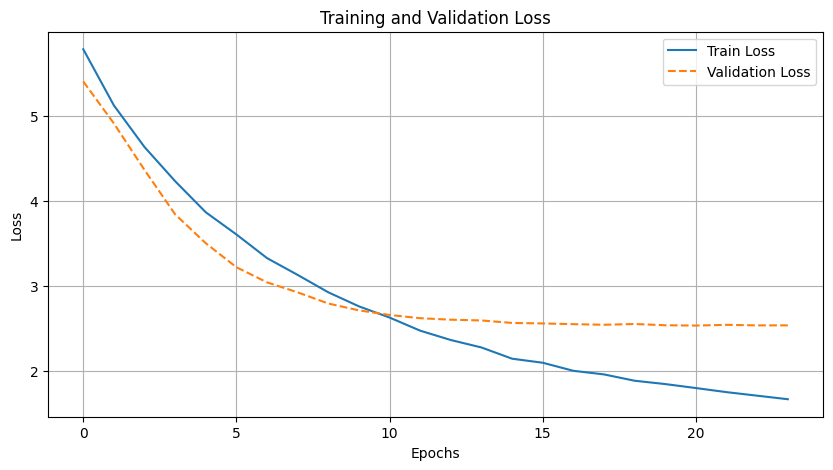

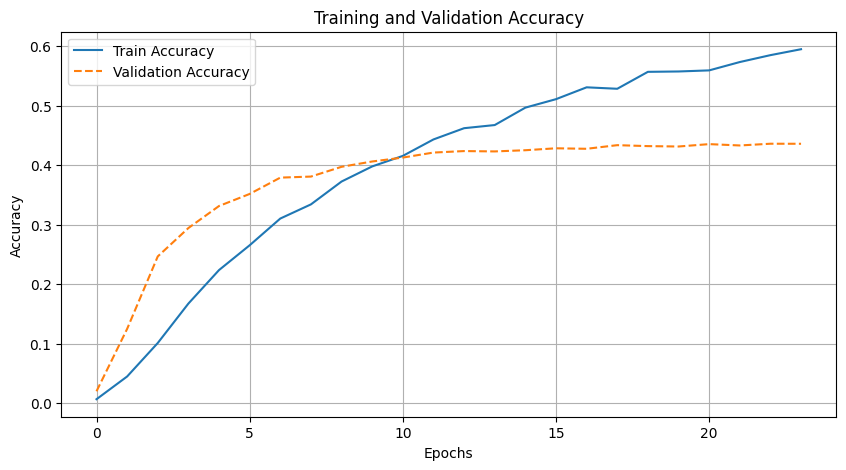

In [ ]:
import matplotlib.pyplot as plt

# === 1. Grafico della Loss ===
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()

# === 2. Grafico dell'Accuracy ===
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid()
plt.show()

Validation e degraded validation performances

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm

# === Caricamento dati preprocessati ===
processed_validation_images = np.load("processed_validation_images.npy")
processed_validation_degraded_images = np.load("processed_validation_degraded_images.npy")
validation_labels = np.load("validation_labels.npy")
validation_degraded_labels = np.load("validation_degraded_labels.npy")

# === Predizioni sul dataset ORIGINALE ===
predictions_validation = np.vstack([
    final_model.predict(processed_validation_images[i:i+32], verbose=0) 
    for i in tqdm(range(0, len(processed_validation_images), 32), desc="Predicting original validation batches")
])

# === Predizioni sul dataset DEGRADATO ===
predictions_degraded = np.vstack([
    final_model.predict(processed_validation_degraded_images[i:i+32], verbose=0) 
    for i in tqdm(range(0, len(processed_validation_degraded_images), 32), desc="Predicting degraded validation batches")
])

# === Ottenere le classi predette ===
predicted_classes_validation = np.argmax(predictions_validation, axis=1)
predicted_classes_degraded = np.argmax(predictions_degraded, axis=1)

# === Calcolo dell'accuracy ===
accuracy_validation = accuracy_score(validation_labels, predicted_classes_validation)
accuracy_degraded = accuracy_score(validation_degraded_labels, predicted_classes_degraded)

print(f"Accuracy sul dataset ORIGINALE: {accuracy_validation * 100:.2f}%")
print(f"Accuracy sul dataset DEGRADATO: {accuracy_degraded * 100:.2f}%")

Predicting original validation batches:   0%|          | 0/375 [00:00<?, ?it/s]

Predicting degraded validation batches:   0%|          | 0/375 [00:00<?, ?it/s]

Accuracy sul dataset ORIGINALE: 43.51%
Accuracy sul dataset DEGRADATO: 34.38%


## Previsioni sull'unlabeled set

In [ ]:
# Percorso della cartella immagini
images_dir = '/kaggle/input/unlabel-dataset/unlabel_processed'

unlabeled_dataset = []

for image_file in tqdm(os.listdir(images_dir), desc="Loading images"):
    image_path = os.path.join(images_dir, image_file)

    if os.path.isfile(image_path) and image_file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
        unlabeled_dataset.append(image_path)

Loading images:   0%|          | 0/113455 [00:00<?, ?it/s]

In [ ]:
import gc  # Per liberare la memoria

def load_and_preprocess_images(image_paths, target_size=(64,64)):
    images = []
    for path in tqdm(image_paths, desc="Preprocessing images"):
        image = Image.open(path).convert('RGB')  # Converte in RGB
        image = image.resize(target_size)  # Resize all'immagine desiderata
        image = np.array(image) / 255.0  # Normalizza tra 0 e 1
        images.append(image)
    return np.array(images)

def generate_predictions_df(final_model, image_paths, batch_size=32):

    processed_images = load_and_preprocess_images(image_paths)
    
    predictions = np.vstack([
        final_model.predict(processed_images[i:i + batch_size], verbose=0)
        for i in tqdm(range(0, len(processed_images), batch_size), desc="Predicting batches")
    ])

    # === 2. Calcola le top 3 classi predette e le rispettive confidences ===
    top_3_indices = np.argsort(predictions, axis=1)[:, -3:][:, ::-1]  # Ottieni gli indici delle top 3 classi
    top_3_confidences = np.sort(predictions, axis=1)[:, -3:][:, ::-1]  # Ottieni le top 3 confidences

    # Separazione delle top 3 per costruire il DataFrame
    predicted_class_1 = top_3_indices[:, 0]
    predicted_class_2 = top_3_indices[:, 1]
    predicted_class_3 = top_3_indices[:, 2]

    confidence_top_1 = top_3_confidences[:, 0]
    confidence_top_2 = top_3_confidences[:, 1]
    confidence_top_3 = top_3_confidences[:, 2]

    # entropia per ogni immagine
    entropies = entropy(predictions.T)

    results_df = pd.DataFrame({
        'Percorso Immagine': image_paths,
        'Classe Predetta 1': predicted_class_1,
        'Confidenza Top 1': confidence_top_1,
        'Classe Predetta 2': predicted_class_2,
        'Confidenza Top 2': confidence_top_2,
        'Classe Predetta 3': predicted_class_3,
        'Confidenza Top 3': confidence_top_3,
        'Entropia (Incertezza)': entropies
    })

    return results_df

In [ ]:
n_chunks = 7
chunk_size = len(unlabeled_dataset) // n_chunks

datasets = [unlabeled_dataset[i:i + chunk_size] for i in range(0, len(unlabeled_dataset), chunk_size)]

if len(unlabeled_dataset) % n_chunks != 0:
    datasets[-1].extend(unlabeled_dataset[n_chunks * chunk_size:])

for idx, dataset in enumerate(datasets):
    globals()[f'un_{str(idx+1).zfill(2)}'] = dataset

l = [globals()[f'un_{str(i).zfill(2)}'] for i in range(1, 8)]

In [ ]:
final_results_df = pd.DataFrame()

for minidataset in l:
    print("Elaborazione di un nuovo minidataset...")

    image_paths = minidataset

    results_df = generate_predictions_df(final_model, image_paths)

    final_results_df = pd.concat([final_results_df, results_df], ignore_index=True)

    del results_df
    gc.collect()  # Forza il garbage collection

Elaborazione di un nuovo minidataset...


Preprocessing images:   0%|          | 0/16207 [00:00<?, ?it/s]

Predicting batches:   0%|          | 0/507 [00:00<?, ?it/s]

Elaborazione di un nuovo minidataset...


Preprocessing images:   0%|          | 0/16207 [00:00<?, ?it/s]

Predicting batches:   0%|          | 0/507 [00:00<?, ?it/s]

Elaborazione di un nuovo minidataset...


Preprocessing images:   0%|          | 0/16207 [00:00<?, ?it/s]

Predicting batches:   0%|          | 0/507 [00:00<?, ?it/s]

Elaborazione di un nuovo minidataset...


Preprocessing images:   0%|          | 0/16207 [00:00<?, ?it/s]

Predicting batches:   0%|          | 0/507 [00:00<?, ?it/s]

Elaborazione di un nuovo minidataset...


Preprocessing images:   0%|          | 0/16207 [00:00<?, ?it/s]

Predicting batches:   0%|          | 0/507 [00:00<?, ?it/s]

Elaborazione di un nuovo minidataset...


Preprocessing images:   0%|          | 0/16207 [00:00<?, ?it/s]

Predicting batches:   0%|          | 0/507 [00:00<?, ?it/s]

Elaborazione di un nuovo minidataset...


Preprocessing images:   0%|          | 0/16207 [00:00<?, ?it/s]

Predicting batches:   0%|          | 0/507 [00:00<?, ?it/s]

In [ ]:
# Visualizziamo i primi risultati ordinati per entropia crescente
final_results_df = final_results_df.sort_values(by='Entropia (Incertezza)', ascending=True)
dataset_per_immagini = final_results_df[final_results_df['Entropia (Incertezza)'] <= 0.05]
dataset_per_immagini = dataset_per_immagini[['Percorso Immagine','Classe Predetta 1']]
print(dataset_per_immagini.shape)
dataset_per_immagini.head(3)

(902, 2)


,Percorso Immagine,Classe Predetta 1
92214,/kaggle/input/unlabel-dataset/unlabel_processe...,0
17882,/kaggle/input/unlabel-dataset/unlabel_processe...,0
89852,/kaggle/input/unlabel-dataset/unlabel_processe...,0


In [ ]:
dataset_per_immagini.to_csv("/kaggle/working/df_per_immagini1.csv", index=False)
'''dataset_per_immagini = pd.read_csv('/kaggle/input/prima-scrematura/df_per_immagini1.csv')
dataset_per_immagini.head(3)'''

"dataset_per_immagini = pd.read_csv('/kaggle/input/prima-scrematura/df_per_immagini1.csv')\ndataset_per_immagini.head(3)"

## Secondo ciclo di aggiunta

In [ ]:
def move_images_to_train(df_images_to_move, train_dataset, unlabel_dataset):

    images_to_move_set = set(df_images_to_move['Percorso Immagine'].values)

    unlabel_dataset = [img_path for img_path in unlabel_dataset if img_path not in images_to_move_set]

    train_dataset.extend(list(df_images_to_move.itertuples(index=False, name=None)))  # Converte il DataFrame in lista di tuple (path, label)

    return train_dataset, unlabel_dataset

filtered_labeled_dataset, unlabeled_dataset = move_images_to_train(dataset_per_immagini, filtered_labeled_dataset, unlabeled_dataset)

print('Nel train ci sono:', len(filtered_labeled_dataset))
print("Nell'unlabel ci sono:", len(unlabeled_dataset))

Nel train ci sono: 5823
Nell'unlabel ci sono: 112553


In [ ]:
def preprocess_image(img_path, target_size=(64,64)):
    img = Image.open(img_path).convert("RGB")  # Converte in RGB
    img = img.resize(target_size)  # Ridimensiona l'immagine
    img_array = np.array(img) / 255.0  # Normalizza i pixel tra [0, 1]
    img_array = np.expand_dims(img_array, axis=0)  # Aggiungi la dimensione batch
    return img_array

images_to_train = [img[0] for img in filtered_labeled_dataset]  # Estrae i percorsi delle immagini
true_labels = [label for _, label in filtered_labeled_dataset]  # Estrae le label corrispondenti

processed_images = np.vstack([preprocess_image(img) for img in images_to_train])

true_labels = np.array(true_labels)

print(f"Numero di immagini preprocessate: {processed_images.shape[0]}")
print(f"Shape di ogni immagine: {processed_images.shape[1:]}")
print(f"Numero di label: {true_labels.shape[0]}")

Numero di immagini preprocessate: 5823
Shape di ogni immagine: (64, 64, 3)
Numero di label: 5823


Alleniamo la rete sui nuovi dati di training

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Resizing, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler, EarlyStopping
import numpy as np

input_layer = Input(shape=(64, 64, 3))

resized_input = Resizing(224, 224)(input_layer)

resnet_kaggle_model.trainable = False

output_layer = resnet_kaggle_model.get_layer("global_average_pooling2d").output
intermediate_model = Model(inputs=resnet_kaggle_model.input, outputs=output_layer)

x = intermediate_model(resized_input)

x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

output = Dense(251, activation='softmax')(x)

final_model = Model(inputs=input_layer, outputs=output)
optimizer = Adam(learning_rate=0.001)
final_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

final_model.summary()

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * np.exp(-0.1)

lr_scheduler = LearningRateScheduler(scheduler)

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',  
    factor=0.5,              
    patience=3,              
    min_lr=1e-6,             
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

processed_validation_images = np.load("processed_validation_images.npy")  # Validation set originale
validation_labels = np.load("validation_labels.npy")  # Label per la validazione originale

history = final_model.fit(
    processed_images,  # Training set corretto
    true_labels,  # Label del training set
    epochs=50,
    batch_size=128,
    validation_data=(processed_validation_images, validation_labels),  # Validation originale
    verbose=1,
    callbacks=[lr_scheduler, reduce_lr, early_stopping]  # Callback inclusi
)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resizing_1 (Resizing)                │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_2 (Functional)            │ (None, 1920)                │      18,321,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │         983,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 251)                 │          32,379 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,505,723 (74.41 MB)

 Trainable params: 1,181,947 (4.51 MB)

 Non-trainable params: 18,323,776 (69.90 MB)

Epoch 1/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - accuracy: 0.0442 - loss: 5.5839 - val_accuracy: 0.0572 - val_loss: 5.2184 - learning_rate: 0.0010
Epoch 2/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 32s 707ms/step - accuracy: 0.1869 - loss: 4.4926 - val_accuracy: 0.1722 - val_loss: 4.6771 - learning_rate: 0.0010
Epoch 3/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 32s 706ms/step - accuracy: 0.2652 - loss: 3.9541 - val_accuracy: 0.2396 - val_loss: 4.1272 - learning_rate: 0.0010
Epoch 4/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 32s 706ms/step - accuracy: 0.3219 - loss: 3.5256 - val_accuracy: 0.2979 - val_loss: 3.6427 - learning_rate: 0.0010
Epoch 5/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 32s 706ms/step - accuracy: 0.3702 - loss: 3.2157 - val_accuracy: 0.3316 - val_loss: 3.2920 - learning_rate: 0.0010
Epoch 6/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 32s 706ms/step - accuracy: 0.3910 - loss: 2.9509 - val_accuracy: 0.3581 - val_loss: 3.0898 - learning_rate: 0.0010
Epoch 7/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 32s 705ms/step - accuracy: 0.4467 - loss: 2.66

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm

processed_validation_images = np.load("processed_validation_images.npy")
processed_validation_degraded_images = np.load("processed_validation_degraded_images.npy")
validation_labels = np.load("validation_labels.npy")
validation_degraded_labels = np.load("validation_degraded_labels.npy")

# === Predizioni sul dataset ORIGINALE ===
predictions_validation = np.vstack([
    final_model.predict(processed_validation_images[i:i+32], verbose=0) 
    for i in tqdm(range(0, len(processed_validation_images), 32), desc="Predicting original validation batches")
])

# === Predizioni sul dataset DEGRADATO ===
predictions_degraded = np.vstack([
    final_model.predict(processed_validation_degraded_images[i:i+32], verbose=0) 
    for i in tqdm(range(0, len(processed_validation_degraded_images), 32), desc="Predicting degraded validation batches")
])

predicted_classes_validation = np.argmax(predictions_validation, axis=1)
predicted_classes_degraded = np.argmax(predictions_degraded, axis=1)

# === Calcolo dell'accuracy ===
accuracy_validation = accuracy_score(validation_labels, predicted_classes_validation)
accuracy_degraded = accuracy_score(validation_degraded_labels, predicted_classes_degraded)

print(f"Accuracy sul dataset ORIGINALE: {accuracy_validation * 100:.2f}%")
print(f"Accuracy sul dataset DEGRADATO: {accuracy_degraded * 100:.2f}%")

Predicting original validation batches:   0%|          | 0/375 [00:00<?, ?it/s]

Predicting degraded validation batches:   0%|          | 0/375 [00:00<?, ?it/s]

Accuracy sul dataset ORIGINALE: 43.08%
Accuracy sul dataset DEGRADATO: 33.97%


## Terzo ciclo

In [ ]:
import gc  # Per liberare la memoria

def load_and_preprocess_images(image_paths, target_size=(64,64)):
    images = []
    for path in tqdm(image_paths, desc="Preprocessing images"):
        image = Image.open(path).convert('RGB')  # Converte in RGB
        image = image.resize(target_size)  # Resize all'immagine desiderata
        image = np.array(image) / 255.0  # Normalizza tra 0 e 1
        images.append(image)
    return np.array(images)

def generate_predictions_df(final_model, image_paths, batch_size=32):
    processed_images = load_and_preprocess_images(image_paths)
    
    predictions = np.vstack([
        final_model.predict(processed_images[i:i + batch_size], verbose=0)
        for i in tqdm(range(0, len(processed_images), batch_size), desc="Predicting batches")
    ])

    top_3_indices = np.argsort(predictions, axis=1)[:, -3:][:, ::-1]  # Otteniamo gli indici delle top 3 classi
    top_3_confidences = np.sort(predictions, axis=1)[:, -3:][:, ::-1] 

    predicted_class_1 = top_3_indices[:, 0]
    predicted_class_2 = top_3_indices[:, 1]
    predicted_class_3 = top_3_indices[:, 2]

    confidence_top_1 = top_3_confidences[:, 0]
    confidence_top_2 = top_3_confidences[:, 1]
    confidence_top_3 = top_3_confidences[:, 2]

    entropies = entropy(predictions.T)

    results_df = pd.DataFrame({
        'Percorso Immagine': image_paths,
        'Classe Predetta 1': predicted_class_1,
        'Confidenza Top 1': confidence_top_1,
        'Classe Predetta 2': predicted_class_2,
        'Confidenza Top 2': confidence_top_2,
        'Classe Predetta 3': predicted_class_3,
        'Confidenza Top 3': confidence_top_3,
        'Entropia (Incertezza)': entropies
    })

    return results_df

In [ ]:
n_chunks = 6
chunk_size = len(unlabeled_dataset) // n_chunks

datasets = [unlabeled_dataset[i:i + chunk_size] for i in range(0, len(unlabeled_dataset), chunk_size)]

if len(unlabeled_dataset) % n_chunks != 0:
    datasets[-1].extend(unlabeled_dataset[n_chunks * chunk_size:])

for idx, dataset in enumerate(datasets):
    globals()[f'un_{str(idx+1).zfill(2)}'] = dataset

l = [globals()[f'un_{str(i).zfill(2)}'] for i in range(1, 7)]

In [ ]:

final_results_df = pd.DataFrame()

for minidataset in l:
    print("Elaborazione di un nuovo minidataset...")

    image_paths = minidataset

    results_df = generate_predictions_df(final_model, image_paths)

    final_results_df = pd.concat([final_results_df, results_df], ignore_index=True)

    del results_df
    gc.collect()  # Forza il garbage collection

Elaborazione di un nuovo minidataset...


Preprocessing images:   0%|          | 0/18758 [00:00<?, ?it/s]

Predicting batches:   0%|          | 0/587 [00:00<?, ?it/s]

Elaborazione di un nuovo minidataset...


Preprocessing images:   0%|          | 0/18758 [00:00<?, ?it/s]

Predicting batches:   0%|          | 0/587 [00:00<?, ?it/s]

Elaborazione di un nuovo minidataset...


Preprocessing images:   0%|          | 0/18758 [00:00<?, ?it/s]

Predicting batches:   0%|          | 0/587 [00:00<?, ?it/s]

Elaborazione di un nuovo minidataset...


Preprocessing images:   0%|          | 0/18758 [00:00<?, ?it/s]

Predicting batches:   0%|          | 0/587 [00:00<?, ?it/s]

Elaborazione di un nuovo minidataset...


Preprocessing images:   0%|          | 0/18758 [00:00<?, ?it/s]

Predicting batches:   0%|          | 0/587 [00:00<?, ?it/s]

Elaborazione di un nuovo minidataset...


Preprocessing images:   0%|          | 0/18758 [00:00<?, ?it/s]

Predicting batches:   0%|          | 0/587 [00:00<?, ?it/s]

In [ ]:
# Visualizziamo i primi risultati ordinati per entropia crescente
final_results_df = final_results_df.sort_values(by='Entropia (Incertezza)', ascending=True)
dataset_per_immagini = final_results_df[final_results_df['Entropia (Incertezza)'] <= 0.05]
dataset_per_immagini = dataset_per_immagini[['Percorso Immagine','Classe Predetta 1']]
print(dataset_per_immagini.shape)
dataset_per_immagini.head(3)

(1673, 2)


,Percorso Immagine,Classe Predetta 1
1920,/kaggle/input/unlabel-dataset/unlabel_processe...,236
6098,/kaggle/input/unlabel-dataset/unlabel_processe...,116
108974,/kaggle/input/unlabel-dataset/unlabel_processe...,236


In [ ]:
dataset_per_immagini.to_csv("/kaggle/working/df_per_immagini2.csv", index=False)

In [ ]:
def move_images_to_train(df_images_to_move, train_dataset, unlabel_dataset):

    images_to_move_set = set(df_images_to_move['Percorso Immagine'].values)

    unlabel_dataset = [img_path for img_path in unlabel_dataset if img_path not in images_to_move_set]

    train_dataset.extend(list(df_images_to_move.itertuples(index=False, name=None)))  # Converte il DataFrame in lista di tuple (path, label)

    return train_dataset, unlabel_dataset

filtered_labeled_dataset, unlabeled_dataset = move_images_to_train(dataset_per_immagini, filtered_labeled_dataset, unlabeled_dataset)

print('Nel train ci sono:', len(filtered_labeled_dataset))
print("Nell'unlabel ci sono:", len(unlabeled_dataset))

Nel train ci sono: 7496
Nell'unlabel ci sono: 110880


In [ ]:
# Funzione per preprocessare un'immagine
def preprocess_image(img_path, target_size=(64,64)):
    img = Image.open(img_path).convert("RGB")  # Converte in RGB
    img = img.resize(target_size)  # Ridimensiona l'immagine
    img_array = np.array(img) / 255.0  # Normalizza i pixel tra [0, 1]
    img_array = np.expand_dims(img_array, axis=0)  # Aggiungi la dimensione batch
    return img_array

images_to_train = [img[0] for img in filtered_labeled_dataset]  # Estrae i percorsi delle immagini
true_labels = [label for _, label in filtered_labeled_dataset]  # Estrae le label corrispondenti

processed_images = np.vstack([preprocess_image(img) for img in images_to_train])

true_labels = np.array(true_labels)

print(f"Numero di immagini preprocessate: {processed_images.shape[0]}")
print(f"Shape di ogni immagine: {processed_images.shape[1:]}")
print(f"Numero di label: {true_labels.shape[0]}")

Numero di immagini preprocessate: 7496
Shape di ogni immagine: (64, 64, 3)
Numero di label: 7496


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Resizing, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler, EarlyStopping
import numpy as np

input_layer = Input(shape=(64, 64, 3))

resized_input = Resizing(224, 224)(input_layer)

resnet_kaggle_model.trainable = False

output_layer = resnet_kaggle_model.get_layer("global_average_pooling2d").output
intermediate_model = Model(inputs=resnet_kaggle_model.input, outputs=output_layer)

x = intermediate_model(resized_input)

x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

output = Dense(251, activation='softmax')(x)

final_model = Model(inputs=input_layer, outputs=output)
optimizer = Adam(learning_rate=0.001)
final_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

final_model.summary()


def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * np.exp(-0.1)

lr_scheduler = LearningRateScheduler(scheduler)

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',  
    factor=0.5,              
    patience=3,              
    min_lr=1e-6,             
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

processed_validation_images = np.load("processed_validation_images.npy")  # Validation set originale
validation_labels = np.load("validation_labels.npy")  # Label per la validazione originale

history = final_model.fit(
    processed_images,  # Training set corretto
    true_labels,  # Label del training set
    epochs=50,
    batch_size=128,
    validation_data=(processed_validation_images, validation_labels),  # Validation originale
    verbose=1,
    callbacks=[lr_scheduler, reduce_lr, early_stopping]  # Callback inclusi
)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resizing_2 (Resizing)                │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_4 (Functional)            │ (None, 1920)                │      18,321,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 512)                 │         983,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 251)                 │          32,379 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,505,723 (74.41 MB)

 Trainable params: 1,181,947 (4.51 MB)

 Non-trainable params: 18,323,776 (69.90 MB)

Epoch 1/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - accuracy: 0.1189 - loss: 5.1676 - val_accuracy: 0.1064 - val_loss: 5.1033 - learning_rate: 0.0010
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 35s 596ms/step - accuracy: 0.3700 - loss: 3.6287 - val_accuracy: 0.1753 - val_loss: 4.4957 - learning_rate: 0.0010
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 35s 596ms/step - accuracy: 0.4286 - loss: 3.0777 - val_accuracy: 0.2317 - val_loss: 3.9401 - learning_rate: 0.0010
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 35s 596ms/step - accuracy: 0.4792 - loss: 2.7028 - val_accuracy: 0.2996 - val_loss: 3.5024 - learning_rate: 0.0010
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 35s 596ms/step - accuracy: 0.5099 - loss: 2.4078 - val_accuracy: 0.3442 - val_loss: 3.1484 - learning_rate: 0.0010
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 35s 595ms/step - accuracy: 0.5607 - loss: 2.1305 - val_accuracy: 0.3718 - val_loss: 2.9344 - learning_rate: 0.0010
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 35s 596ms/step - accuracy: 0.5791 - loss: 1.95

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm

processed_validation_images = np.load("processed_validation_images.npy")
processed_validation_degraded_images = np.load("processed_validation_degraded_images.npy")
validation_labels = np.load("validation_labels.npy")
validation_degraded_labels = np.load("validation_degraded_labels.npy")

# === Predizioni sul dataset ORIGINALE ===
predictions_validation = np.vstack([
    final_model.predict(processed_validation_images[i:i+32], verbose=0) 
    for i in tqdm(range(0, len(processed_validation_images), 32), desc="Predicting original validation batches")
])

# === Predizioni sul dataset DEGRADATO ===
predictions_degraded = np.vstack([
    final_model.predict(processed_validation_degraded_images[i:i+32], verbose=0) 
    for i in tqdm(range(0, len(processed_validation_degraded_images), 32), desc="Predicting degraded validation batches")
])

# === Ottenere le classi predette ===
predicted_classes_validation = np.argmax(predictions_validation, axis=1)
predicted_classes_degraded = np.argmax(predictions_degraded, axis=1)

# === Calcolo dell'accuracy ===
accuracy_validation = accuracy_score(validation_labels, predicted_classes_validation)
accuracy_degraded = accuracy_score(validation_degraded_labels, predicted_classes_degraded)

print(f"Accuracy sul dataset ORIGINALE: {accuracy_validation * 100:.2f}%")
print(f"Accuracy sul dataset DEGRADATO: {accuracy_degraded * 100:.2f}%")

Predicting original validation batches:   0%|          | 0/375 [00:00<?, ?it/s]

Predicting degraded validation batches:   0%|          | 0/375 [00:00<?, ?it/s]

Accuracy sul dataset ORIGINALE: 43.46%
Accuracy sul dataset DEGRADATO: 34.09%


## Allenamento finale

In [ ]:
import gc  # Per liberare la memoria

def load_and_preprocess_images(image_paths, target_size=(64,64)):
    images = []
    for path in tqdm(image_paths, desc="Preprocessing images"):
        image = Image.open(path).convert('RGB')  # Converte in RGB
        image = image.resize(target_size)  # Resize all'immagine desiderata
        image = np.array(image) / 255.0  # Normalizza tra 0 e 1
        images.append(image)
    return np.array(images)

def generate_predictions_df(final_model, image_paths, batch_size=32):

    processed_images = load_and_preprocess_images(image_paths)
    
    predictions = np.vstack([
        final_model.predict(processed_images[i:i + batch_size], verbose=0)
        for i in tqdm(range(0, len(processed_images), batch_size), desc="Predicting batches")
    ])

    top_3_indices = np.argsort(predictions, axis=1)[:, -3:][:, ::-1]  # Ottieni gli indici delle top 3 classi
    top_3_confidences = np.sort(predictions, axis=1)[:, -3:][:, ::-1]  # Ottieni le top 3 confidences

    predicted_class_1 = top_3_indices[:, 0]
    predicted_class_2 = top_3_indices[:, 1]
    predicted_class_3 = top_3_indices[:, 2]

    confidence_top_1 = top_3_confidences[:, 0]
    confidence_top_2 = top_3_confidences[:, 1]
    confidence_top_3 = top_3_confidences[:, 2]

    entropies = entropy(predictions.T)

    results_df = pd.DataFrame({
        'Percorso Immagine': image_paths,
        'Classe Predetta 1': predicted_class_1,
        'Confidenza Top 1': confidence_top_1,
        'Classe Predetta 2': predicted_class_2,
        'Confidenza Top 2': confidence_top_2,
        'Classe Predetta 3': predicted_class_3,
        'Confidenza Top 3': confidence_top_3,
        'Entropia (Incertezza)': entropies
    })

    return results_df

In [ ]:
n_chunks = 5
chunk_size = len(unlabeled_dataset) // n_chunks

datasets = [unlabeled_dataset[i:i + chunk_size] for i in range(0, len(unlabeled_dataset), chunk_size)]

if len(unlabeled_dataset) % n_chunks != 0:
    datasets[-1].extend(unlabeled_dataset[n_chunks * chunk_size:])

for idx, dataset in enumerate(datasets):
    globals()[f'un_{str(idx+1).zfill(2)}'] = dataset

l = [globals()[f'un_{str(i).zfill(2)}'] for i in range(1, 6)]

In [ ]:
# === Inizializza il DataFrame vuoto per i risultati finali ===
final_results_df = pd.DataFrame()

for minidataset in l:
    print("Elaborazione di un nuovo minidataset...")

    image_paths = minidataset

    results_df = generate_predictions_df(final_model, image_paths)

    final_results_df = pd.concat([final_results_df, results_df], ignore_index=True)

    del results_df
    gc.collect()  # Forza il garbage collection

Elaborazione di un nuovo minidataset...


Preprocessing images:   0%|          | 0/22176 [00:00<?, ?it/s]

Predicting batches:   0%|          | 0/693 [00:00<?, ?it/s]

Elaborazione di un nuovo minidataset...


Preprocessing images:   0%|          | 0/22176 [00:00<?, ?it/s]

Predicting batches:   0%|          | 0/693 [00:00<?, ?it/s]

Elaborazione di un nuovo minidataset...


Preprocessing images:   0%|          | 0/22176 [00:00<?, ?it/s]

Predicting batches:   0%|          | 0/693 [00:00<?, ?it/s]

Elaborazione di un nuovo minidataset...


Preprocessing images:   0%|          | 0/22176 [00:00<?, ?it/s]

Predicting batches:   0%|          | 0/693 [00:00<?, ?it/s]

Elaborazione di un nuovo minidataset...


Preprocessing images:   0%|          | 0/22176 [00:00<?, ?it/s]

Predicting batches:   0%|          | 0/693 [00:00<?, ?it/s]

In [ ]:
# Visualizza i primi risultati ordinati per entropia crescente
final_results_df = final_results_df.sort_values(by='Entropia (Incertezza)', ascending=True)
dataset_per_immagini = final_results_df[final_results_df['Entropia (Incertezza)'] <= 0.05]
dataset_per_immagini = dataset_per_immagini[['Percorso Immagine','Classe Predetta 1']]
print(dataset_per_immagini.shape)
dataset_per_immagini.head(3)

(2709, 2)


,Percorso Immagine,Classe Predetta 1
24370,/kaggle/input/unlabel-dataset/unlabel_processe...,86
51976,/kaggle/input/unlabel-dataset/unlabel_processe...,194
35221,/kaggle/input/unlabel-dataset/unlabel_processe...,114


In [ ]:
dataset_per_immagini.to_csv("/kaggle/working/df_per_immagini3.csv", index=False)

In [ ]:
def move_images_to_train(df_images_to_move, train_dataset, unlabel_dataset):

    images_to_move_set = set(df_images_to_move['Percorso Immagine'].values)

    unlabel_dataset = [img_path for img_path in unlabel_dataset if img_path not in images_to_move_set]

    train_dataset.extend(list(df_images_to_move.itertuples(index=False, name=None)))  # Converte il DataFrame in lista di tuple (path, label)

    return train_dataset, unlabel_dataset

filtered_labeled_dataset, unlabeled_dataset = move_images_to_train(dataset_per_immagini, filtered_labeled_dataset, unlabeled_dataset)

print('Nel train ci sono:', len(filtered_labeled_dataset))
print("Nell'unlabel ci sono:", len(unlabeled_dataset))

Nel train ci sono: 10205
Nell'unlabel ci sono: 108171


In [ ]:
# Funzione per preprocessare un'immagine
def preprocess_image(img_path, target_size=(64,64)):
    img = Image.open(img_path).convert("RGB")  # Converte in RGB
    img = img.resize(target_size)  # Ridimensiona l'immagine
    img_array = np.array(img) / 255.0  # Normalizza i pixel tra [0, 1]
    img_array = np.expand_dims(img_array, axis=0)  # Aggiungi la dimensione batch
    return img_array

images_to_train = [img[0] for img in filtered_labeled_dataset]  # Estrae i percorsi delle immagini
true_labels = [label for _, label in filtered_labeled_dataset]  # Estrae le label corrispondenti

processed_images = np.vstack([preprocess_image(img) for img in images_to_train])

true_labels = np.array(true_labels)

print(f"Numero di immagini preprocessate: {processed_images.shape[0]}")
print(f"Shape di ogni immagine: {processed_images.shape[1:]}")
print(f"Numero di label: {true_labels.shape[0]}")

Numero di immagini preprocessate: 10205
Shape di ogni immagine: (64, 64, 3)
Numero di label: 10205


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Resizing, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler, EarlyStopping
import numpy as np

input_layer = Input(shape=(64, 64, 3))

resized_input = Resizing(224, 224)(input_layer)

resnet_kaggle_model.trainable = False

output_layer = resnet_kaggle_model.get_layer("global_average_pooling2d").output
intermediate_model = Model(inputs=resnet_kaggle_model.input, outputs=output_layer)

x = intermediate_model(resized_input)

x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

output = Dense(251, activation='softmax')(x)

final_model = Model(inputs=input_layer, outputs=output)
optimizer = Adam(learning_rate=0.001)
final_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

final_model.summary()

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * np.exp(-0.1)

lr_scheduler = LearningRateScheduler(scheduler)

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',  
    factor=0.5,              
    patience=3,              
    min_lr=1e-6,             
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

processed_validation_images = np.load("processed_validation_images.npy")  # Validation set originale
validation_labels = np.load("validation_labels.npy")  # Label per la validazione originale

history = final_model.fit(
    processed_images,  # Training set corretto
    true_labels,  # Label del training set
    epochs=50,
    batch_size=128,
    validation_data=(processed_validation_images, validation_labels),  # Validation originale
    verbose=1,
    callbacks=[lr_scheduler, reduce_lr, early_stopping]  # Callback inclusi
)

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resizing_3 (Resizing)                │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_6 (Functional)            │ (None, 1920)                │      18,321,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 512)                 │         983,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 251)                 │          32,379 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,505,723 (74.41 MB)

 Trainable params: 1,181,947 (4.51 MB)

 Non-trainable params: 18,323,776 (69.90 MB)

Epoch 1/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - accuracy: 0.2147 - loss: 4.6546 - val_accuracy: 0.1404 - val_loss: 4.8028 - learning_rate: 0.0010
Epoch 2/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 39s 493ms/step - accuracy: 0.5562 - loss: 2.6390 - val_accuracy: 0.1785 - val_loss: 4.2752 - learning_rate: 0.0010
Epoch 3/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 39s 493ms/step - accuracy: 0.5925 - loss: 2.2175 - val_accuracy: 0.2427 - val_loss: 3.7632 - learning_rate: 0.0010
Epoch 4/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 40s 497ms/step - accuracy: 0.6118 - loss: 1.9660 - val_accuracy: 0.3033 - val_loss: 3.3220 - learning_rate: 0.0010
Epoch 5/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 39s 496ms/step - accuracy: 0.6494 - loss: 1.7214 - val_accuracy: 0.3476 - val_loss: 3.0506 - learning_rate: 0.0010
Epoch 6/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 39s 497ms/step - accuracy: 0.6835 - loss: 1.4836 - val_accuracy: 0.3818 - val_loss: 2.8507 - learning_rate: 0.0010
Epoch 7/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 39s 495ms/step - accuracy: 0.6971 - loss: 1.39

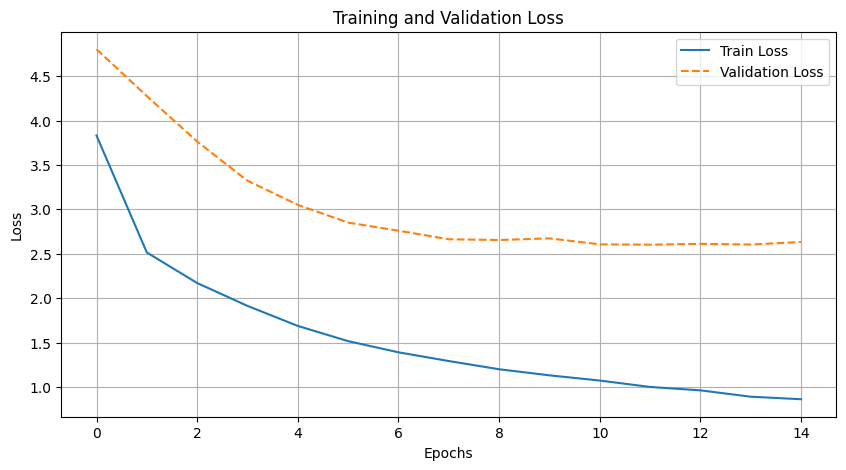

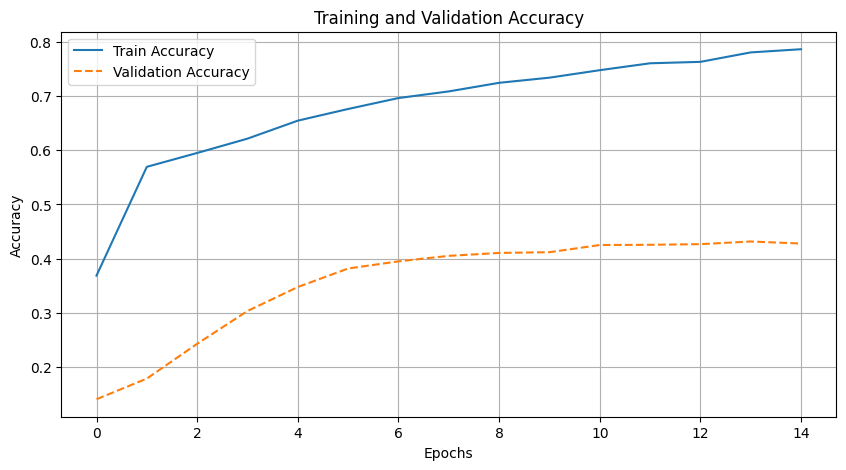

In [ ]:
import matplotlib.pyplot as plt

# === 1. Grafico della Loss ===
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()

# === 2. Grafico dell'Accuracy ===
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid()
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm

processed_validation_images = np.load("processed_validation_images.npy")
processed_validation_degraded_images = np.load("processed_validation_degraded_images.npy")
validation_labels = np.load("validation_labels.npy")
validation_degraded_labels = np.load("validation_degraded_labels.npy")

# === Predizioni sul dataset ORIGINALE ===
predictions_validation = np.vstack([
    final_model.predict(processed_validation_images[i:i+32], verbose=0) 
    for i in tqdm(range(0, len(processed_validation_images), 32), desc="Predicting original validation batches")
])

# === Predizioni sul dataset DEGRADATO ===
predictions_degraded = np.vstack([
    final_model.predict(processed_validation_degraded_images[i:i+32], verbose=0) 
    for i in tqdm(range(0, len(processed_validation_degraded_images), 32), desc="Predicting degraded validation batches")
])

# === Ottenere le classi predette ===
predicted_classes_validation = np.argmax(predictions_validation, axis=1)
predicted_classes_degraded = np.argmax(predictions_degraded, axis=1)

# === Calcolo dell'accuracy ===
accuracy_validation = accuracy_score(validation_labels, predicted_classes_validation)
accuracy_degraded = accuracy_score(validation_degraded_labels, predicted_classes_degraded)

print(f"Accuracy sul dataset ORIGINALE: {accuracy_validation * 100:.2f}%")
print(f"Accuracy sul dataset DEGRADATO: {accuracy_degraded * 100:.2f}%")

Predicting original validation batches:   0%|          | 0/375 [00:00<?, ?it/s]

Predicting degraded validation batches:   0%|          | 0/375 [00:00<?, ?it/s]

Accuracy sul dataset ORIGINALE: 42.55%
Accuracy sul dataset DEGRADATO: 33.45%


# Alleniamo un modello con data augmentation

In [ ]:
import os
import pandas as pd
from tqdm.notebook import tqdm

csv_file = '/kaggle/input/label-train-info/train_small.csv'  # Percorso del file CSV
images_dir = '/kaggle/input/solo-train-finale/solo_train'  # Percorso della cartella immagini

df_labels = pd.read_csv(csv_file, header=None, names=['filename', 'label'])

labeled_dataset = []

for _, row in tqdm(df_labels.iterrows(), total=len(df_labels), desc="Matching images"):
    image_file = row['filename']
    label = row['label']
    image_path = os.path.join(images_dir, image_file)

    if os.path.exists(image_path):
        labeled_dataset.append((image_path, label))

print(f"Numero di immagini matchate: {len(labeled_dataset)}")

In [ ]:
outliers_csv = '/kaggle/input/immagini-da-levare-dal-train/outliers_to_delete (1).csv'
outliers_df = pd.read_csv(outliers_csv, header=None, names=['filename'])

outliers_to_delete = set(outliers_df['filename'].tolist())

filtered_labeled_dataset = [
    (img_path, label) for img_path, label in labeled_dataset 
    if os.path.basename(img_path) not in outliers_to_delete
]

print(f"Numero di immagini rimanenti dopo il filtro: {len(filtered_labeled_dataset)}")

Numero di immagini rimanenti dopo il filtro: 4921


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation

def custom_layer_wrapper(layer_class):
    def wrapper(*args, **kwargs):
        if 'name' in kwargs:
            kwargs['name'] = kwargs['name'].replace('/', '_')  # Sostituisce "/" con "_"
        return layer_class(*args, **kwargs)
    return wrapper

custom_conv2d = custom_layer_wrapper(Conv2D)
custom_batch_norm = custom_layer_wrapper(BatchNormalization)
custom_activation = custom_layer_wrapper(Activation)

model_path = '/kaggle/input/modellone/other/default/1/RESNET_Kaggle.hdf5'

resnet_kaggle_model = tf.keras.models.load_model(
    model_path,
    custom_objects={
        'Conv2D': custom_conv2d,
        'BatchNormalization': custom_batch_norm,
        'Activation': custom_activation
    }
)

In [ ]:

images_dir = '/kaggle/input/unlabel-for-transformer/unlabel_processed'

unlabeled_dataset = []

for image_file in tqdm(os.listdir(images_dir), desc="Loading images"):
    image_path = os.path.join(images_dir, image_file)

    if os.path.isfile(image_path) and image_file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
        unlabeled_dataset.append(image_path)

Loading images:   0%|          | 0/113455 [00:00<?, ?it/s]

In [ ]:
df1_add = pd.read_csv('/kaggle/input/immagini-da-aggiungere/df_per_immagini1_vero.csv')
df2_add = pd.read_csv('/kaggle/input/immagini-da-aggiungere/df_per_immagini2.csv')
df3_add = pd.read_csv('/kaggle/input/immagini-da-aggiungere/df_per_immagini3.csv')
lista_percorsi = {}

ldf1 = []
for _, row in df1_add.iterrows():
    percorso = row['Percorso Immagine']
    classe = row['Classe Predetta 1']
    t = (percorso, classe)
    ldf1.append(t)
    if percorso not in lista_percorsi:
        lista_percorsi[percorso] = classe

ldf2 = []
for _, row in df2_add.iterrows():
    percorso = row['Percorso Immagine']
    classe = row['Classe Predetta 1']
    t = (percorso, classe)
    ldf2.append(t)
    if percorso not in lista_percorsi:
        lista_percorsi[percorso] = classe

ldf3 = []
for _, row in df3_add.iterrows():
    percorso = row['Percorso Immagine']
    classe = row['Classe Predetta 1']
    t = (percorso, classe)
    ldf3.append(t)
    if percorso not in lista_percorsi:
        lista_percorsi[percorso] = classe

print('In totale vengono aggiunte',len(ldf1)+len(ldf2)+len(ldf3),'imamgini')

In totale vengono aggiunte 5284 imamgini


In [ ]:
for img_path, label in lista_percorsi.items():
    filename = os.path.basename(img_path)  # Estrai solo il nome del file
    new_path = os.path.join(images_dir, filename)  # Crea il nuovo percorso

    if new_path in unlabeled_dataset and filename not in outliers_to_delete:
        filtered_labeled_dataset.append((new_path, label))

print(f"Numero di immagini rimanenti dopo il filtro: {len(filtered_labeled_dataset)}")

Numero di immagini rimanenti dopo il filtro: 10205


processiamo le immagini

In [ ]:
# Funzione per preprocessare un'immagine
def preprocess_image(img_path, target_size=(64,64)):
    img = Image.open(img_path).convert("RGB")  # Converte in RGB
    img = img.resize(target_size)  # Ridimensiona l'immagine
    img_array = np.array(img) / 255.0  # Normalizza i pixel tra [0, 1]
    img_array = np.expand_dims(img_array, axis=0)  # Aggiungi la dimensione batch
    return img_array

# labeled_dataset contiene (image_path, label)
images_to_train = [img[0] for img in filtered_labeled_dataset]  # Estrae i percorsi delle immagini
true_labels = [label for _, label in filtered_labeled_dataset]  # Estrae le label corrispondenti

processed_images = np.vstack([preprocess_image(img) for img in images_to_train])

true_labels = np.array(true_labels)

print(f"Numero di immagini preprocessate: {processed_images.shape[0]}")
print(f"Shape di ogni immagine: {processed_images.shape[1:]}")
print(f"Numero di label: {true_labels.shape[0]}")

Numero di immagini preprocessate: 10205
Shape di ogni immagine: (64, 64, 3)
Numero di label: 10205


In [ ]:
import os
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from PIL import Image
from sklearn.metrics import accuracy_score

# === Funzione per abbinare immagini e label ===
def match_images_and_labels(csv_file, images_dir):
    df_labels = pd.read_csv(csv_file, header=None, names=['filename', 'label'])
    matched_dataset = []
    
    for _, row in tqdm(df_labels.iterrows(), total=len(df_labels), desc="Matching images"):
        image_file = row['filename']
        label = row['label']
        image_path = os.path.join(images_dir, image_file)

        if os.path.exists(image_path):
            matched_dataset.append((image_path, label))

    print(f"Numero di immagini matchate: {len(matched_dataset)}")
    return matched_dataset

# === Funzione per preprocessare un'immagine ===
def preprocess_image(img_path, target_size=(64,64)):
    img = Image.open(img_path).convert("RGB")
    img = img.resize(target_size)
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Aggiungi la dimensione batch
    return img_array

# === Caricamento del dataset ORIGINALE ===
validation_csv_file = '/kaggle/input/label-validation/val_info.csv'
validation_images_dir = '/kaggle/input/validation-set/val_set'

validation_dataset = match_images_and_labels(validation_csv_file, validation_images_dir)

# === Caricamento del dataset DEGRADATO ===
validation_degraded_images_dir = '/kaggle/input/validation-degradato/val_set_degraded'

validation_degraded_dataset = match_images_and_labels(validation_csv_file, validation_degraded_images_dir)

validation_images = [img[0] for img in validation_dataset]
validation_labels = [label for _, label in validation_dataset]

validation_degraded_images = [img[0] for img in validation_degraded_dataset]
validation_degraded_labels = [label for _, label in validation_degraded_dataset]

# === Preprocessing immagini ORIGINALE ===
processed_validation_images = np.vstack([
    preprocess_image(img) for img in tqdm(validation_images, desc="Preprocessing original validation images", total=len(validation_images))
])

# === Preprocessing immagini DEGRADATE ===
processed_validation_degraded_images = np.vstack([
    preprocess_image(img) for img in tqdm(validation_degraded_images, desc="Preprocessing degraded validation images", total=len(validation_degraded_images))
])

# === Converti le label in NumPy array ===
validation_labels = np.array(validation_labels)
validation_degraded_labels = np.array(validation_degraded_labels)

# === Salvataggio in memoria per uso successivo ===
np.save("processed_validation_images.npy", processed_validation_images)
np.save("processed_validation_degraded_images.npy", processed_validation_degraded_images)
np.save("validation_labels.npy", validation_labels)
np.save("validation_degraded_labels.npy", validation_degraded_labels)

print("Preprocessing completato e dati salvati.")


Matching images:   0%|          | 0/11994 [00:00<?, ?it/s]

Numero di immagini matchate: 11994


Matching images:   0%|          | 0/11994 [00:00<?, ?it/s]

Numero di immagini matchate: 11994


Preprocessing original validation images:   0%|          | 0/11994 [00:00<?, ?it/s]

Preprocessing degraded validation images:   0%|          | 0/11994 [00:00<?, ?it/s]

Preprocessing completato e dati salvati.


In [ ]:
images_dir = "/kaggle/input/val-set-enhanced"

validation_enhanced = []

for class_name in tqdm(sorted(os.listdir(images_dir)), desc="Scanning classes"):
    class_path = os.path.join(images_dir, class_name)

    if os.path.isdir(class_path):
        for image_file in os.listdir(class_path):
            image_path = os.path.join(class_path, image_file)
            validation_enhanced.append((image_path, int(class_name)))  # Label = nome della cartella

df_validation = pd.DataFrame(validation_enhanced, columns=['image_path', 'label'])

print(f"Numero totale di immagini caricate: {len(validation_enhanced)}")

Scanning classes:   0%|          | 0/251 [00:00<?, ?it/s]

Numero totale di immagini caricate: 11994


In [ ]:
import os
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from PIL import Image

def preprocess_image(img_path, target_size=(64,64)):
    img = Image.open(img_path).convert("RGB")
    img = img.resize(target_size)
    img_array = np.array(img) / 255.0  # Normalizzazione [0,1]
    img_array = np.expand_dims(img_array, axis=0)  # Aggiungi la dimensione batch
    return img_array

validation_enhanced_images = [img[0] for img in validation_enhanced]
validation_enhanced_labels = [label for _, label in validation_enhanced]

# === Preprocessing immagini ===
processed_validation_enhanced_images = np.vstack([
    preprocess_image(img) for img in tqdm(validation_enhanced_images, desc="Preprocessing validation enhanced images", total=len(validation_enhanced_images))
])

validation_enhanced_labels = np.array(validation_enhanced_labels)

# === Salvataggio in memoria per uso successivo ===
np.save("processed_validation_enhanced_images.npy", processed_validation_enhanced_images)
np.save("validation_enhanced_labels.npy", validation_enhanced_labels)

print("Preprocessing completato e dati salvati.")

Preprocessing validation enhanced images:   0%|          | 0/11994 [00:00<?, ?it/s]

Preprocessing completato e dati salvati.


Passiamo alla rete

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Resizing, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler, EarlyStopping
import numpy as np

input_layer = Input(shape=(64, 64, 3))

data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),  # Flip sia orizzontale che verticale
    RandomRotation(0.2),  # Aumento della rotazione massima
    RandomContrast(0.1),  # Maggiore variazione di contrasto
])(input_layer)

resized_input = Resizing(224, 224)(data_augmentation)
resnet_kaggle_model.trainable = False

output_layer = resnet_kaggle_model.get_layer("global_average_pooling2d").output
intermediate_model = Model(inputs=resnet_kaggle_model.input, outputs=output_layer)

x = intermediate_model(resized_input)

x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

output = Dense(251, activation='softmax')(x)

final_model = Model(inputs=input_layer, outputs=output)
optimizer = Adam(learning_rate=0.001)
final_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

final_model.summary()

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * np.exp(-0.1)


lr_scheduler = LearningRateScheduler(scheduler)

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',  
    factor=0.5,              
    patience=3,              
    min_lr=1e-6,             
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

processed_validation_images = np.load("processed_validation_images.npy")  # Validation set originale
validation_labels = np.load("validation_labels.npy")  # Label per la validazione originale

history = final_model.fit(
    processed_images,  # Training set corretto
    true_labels,  # Label del training set
    epochs=100,
    batch_size=128,
    validation_data=(processed_validation_images, validation_labels),  # Validation originale
    verbose=1,
    callbacks=[lr_scheduler, reduce_lr, early_stopping]  # Callback inclusi   lr_scheduler (come primo)
)

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resizing_2 (Resizing)                │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_14 (Functional)           │ (None, 1920)                │      18,321,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 512)                 │         983,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 251)                 │          32,379 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,505,723 (74.41 MB)

 Trainable params: 1,181,947 (4.51 MB)

 Non-trainable params: 18,323,776 (69.90 MB)

Epoch 1/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - accuracy: 0.1548 - loss: 4.9707 - val_accuracy: 0.1176 - val_loss: 4.9075 - learning_rate: 0.0010
Epoch 2/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 75s 942ms/step - accuracy: 0.4660 - loss: 3.1418 - val_accuracy: 0.1603 - val_loss: 4.4597 - learning_rate: 0.0010
Epoch 3/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 75s 942ms/step - accuracy: 0.5206 - loss: 2.6975 - val_accuracy: 0.1860 - val_loss: 4.0855 - learning_rate: 0.0010
Epoch 4/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 75s 942ms/step - accuracy: 0.5407 - loss: 2.4709 - val_accuracy: 0.2191 - val_loss: 3.7944 - learning_rate: 0.0010
Epoch 5/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 75s 942ms/step - accuracy: 0.5514 - loss: 2.3017 - val_accuracy: 0.2525 - val_loss: 3.5289 - learning_rate: 0.0010
Epoch 6/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 75s 942ms/step - accuracy: 0.5686 - loss: 2.1689 - val_accuracy: 0.2901 - val_loss: 3.2886 - learning_rate: 0.0010
Epoch 7/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 75s 941ms/step - accuracy: 0.5847 - los

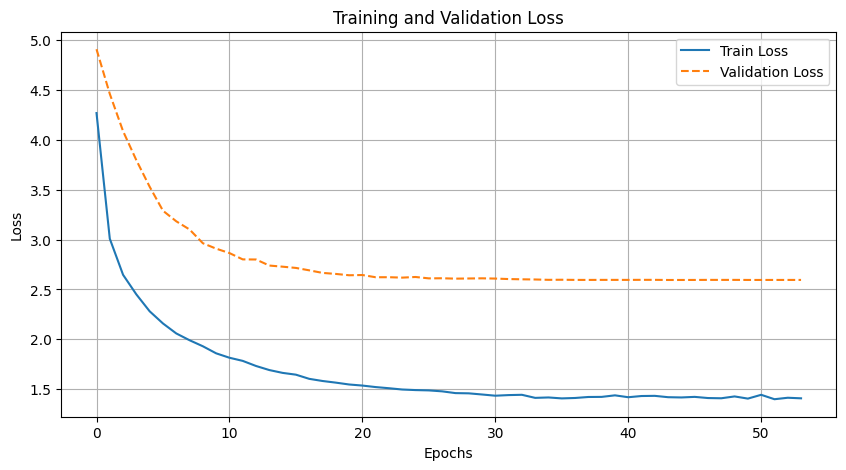

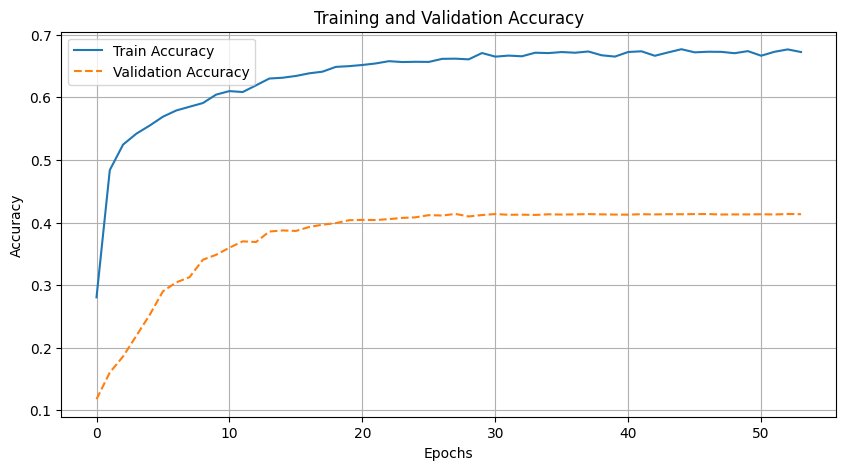

In [ ]:
import matplotlib.pyplot as plt

# === 1. Grafico della Loss ===
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()

# === 2. Grafico dell'Accuracy ===
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# === Caricamento dati preprocessati ===
processed_validation_images = np.load("processed_validation_images.npy")
processed_validation_degraded_images = np.load("processed_validation_degraded_images.npy")
validation_labels = np.load("validation_labels.npy")
validation_degraded_labels = np.load("validation_degraded_labels.npy")

# === Predizioni sul dataset ORIGINALE ===
predictions_validation = np.vstack([
    final_model.predict(processed_validation_images[i:i+32], verbose=0) 
    for i in tqdm(range(0, len(processed_validation_images), 32), desc="Predicting original validation batches")
])

# === Predizioni sul dataset DEGRADATO ===
predictions_degraded = np.vstack([
    final_model.predict(processed_validation_degraded_images[i:i+32], verbose=0) 
    for i in tqdm(range(0, len(processed_validation_degraded_images), 32), desc="Predicting degraded validation batches")
])

predicted_classes_validation = np.argmax(predictions_validation, axis=1)
predicted_classes_degraded = np.argmax(predictions_degraded, axis=1)

accuracy_validation = accuracy_score(validation_labels, predicted_classes_validation)
accuracy_degraded = accuracy_score(validation_degraded_labels, predicted_classes_degraded)

print(f"Accuracy sul dataset ORIGINALE: {accuracy_validation * 100:.2f}%")
print(f"Accuracy sul dataset DEGRADATO: {accuracy_degraded * 100:.2f}%")

Predicting original validation batches:   0%|          | 0/375 [00:00<?, ?it/s]

Predicting degraded validation batches:   0%|          | 0/375 [00:00<?, ?it/s]

Accuracy sul dataset ORIGINALE: 41.33%
Accuracy sul dataset DEGRADATO: 33.48%


## Quali sono le classi predette meglio?

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score

precision_validation = precision_score(validation_labels, predicted_classes_validation, average=None)
precision_degraded = precision_score(validation_degraded_labels, predicted_classes_degraded, average=None)

unique_classes = sorted(set(validation_labels))

# Calcolo dell'accuracy per classe 
accuracy_per_class_validation = []
accuracy_per_class_degraded = []

for cls in tqdm(unique_classes, desc="Calcolando accuracy per classe"):
    accuracy_val = accuracy_score(
        validation_labels[validation_labels == cls], 
        predicted_classes_validation[validation_labels == cls]
    )
    accuracy_deg = accuracy_score(
        validation_degraded_labels[validation_degraded_labels == cls], 
        predicted_classes_degraded[validation_degraded_labels == cls]
    )

    accuracy_per_class_validation.append(accuracy_val)
    accuracy_per_class_degraded.append(accuracy_deg)

df_metrics = pd.DataFrame({
    "Class": unique_classes,
    "Accuracy_Original": accuracy_per_class_validation,
    "Precision_Original": precision_validation,
    "Accuracy_Degraded": accuracy_per_class_degraded,
    "Precision_Degraded": precision_degraded
})
df_metrics = df_metrics.sort_values(by="Accuracy_Original", ascending=False)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Calcolando accuracy per classe: 100%|██████████| 251/251 [00:00<00:00, 1654.76it/s]


In [ ]:
df_metrics.head(3)

,Class,Accuracy_Original,Precision_Original,Accuracy_Degraded,Precision_Degraded
250,250,0.900000,0.569620,0.800000,0.526316
49,49,0.896552,0.536082,0.758621,0.407407
89,89,0.886364,0.573529,0.727273,0.571429


## Verifichiamo anche sul validation migliorato

In [ ]:
import numpy as np
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score

processed_validation_enhanced_images = np.load("processed_validation_enhanced_images.npy")
validation_enhanced_labels = np.load("validation_enhanced_labels.npy")

predictions_enhanced = np.vstack([
    final_model.predict(processed_validation_enhanced_images[i:i+32], verbose=0) 
    for i in tqdm(range(0, len(processed_validation_enhanced_images), 32), desc="Predicting enhanced validation batches")
])

predicted_classes_enhanced = np.argmax(predictions_enhanced, axis=1)

accuracy_enhanced = accuracy_score(validation_enhanced_labels, predicted_classes_enhanced)

print(f"Accuracy sul dataset ENHANCED: {accuracy_enhanced * 100:.2f}%")

Predicting enhanced validation batches:   0%|          | 0/375 [00:00<?, ?it/s]

Accuracy sul dataset ENHANCED: 36.58%


In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score

precision_validation = precision_score(validation_labels, predicted_classes_validation, average=None)
precision_degraded = precision_score(validation_degraded_labels, predicted_classes_degraded, average=None)
precision_enhanced = precision_score(validation_enhanced_labels, predicted_classes_enhanced, average=None)

unique_classes = sorted(set(validation_labels))

accuracy_per_class_validation = []
accuracy_per_class_degraded = []
accuracy_per_class_enhanced = []

predicted_classes_per_target_validation = []
predicted_classes_per_target_degraded = []
predicted_classes_per_target_enhanced = []

for cls in tqdm(unique_classes, desc="Calcolando accuracy per classe"):

    idx_val = validation_labels == cls
    idx_deg = validation_degraded_labels == cls
    idx_enh = validation_enhanced_labels == cls

    predicted_validation = predicted_classes_validation[idx_val]
    predicted_degraded = predicted_classes_degraded[idx_deg]
    predicted_enhanced = predicted_classes_enhanced[idx_enh]


    accuracy_val = accuracy_score(validation_labels[idx_val], predicted_validation)
    accuracy_deg = accuracy_score(validation_degraded_labels[idx_deg], predicted_degraded)
    accuracy_enh = accuracy_score(validation_enhanced_labels[idx_enh], predicted_enhanced)

    accuracy_per_class_validation.append(accuracy_val)
    accuracy_per_class_degraded.append(accuracy_deg)
    accuracy_per_class_enhanced.append(accuracy_enh)

    predicted_classes_per_target_validation.append(list(predicted_validation))
    predicted_classes_per_target_degraded.append(list(predicted_degraded))
    predicted_classes_per_target_enhanced.append(list(predicted_enhanced))

df_metrics = pd.DataFrame({
    "Class_Target": unique_classes,
    "Accuracy_Original": accuracy_per_class_validation,
    "Precision_Original": precision_validation,
    "Class_Predicted_Original": predicted_classes_per_target_validation,
    "Accuracy_Degraded": accuracy_per_class_degraded,
    "Precision_Degraded": precision_degraded,
    "Class_Predicted_Degraded": predicted_classes_per_target_degraded,
    "Accuracy_Enhanced": accuracy_per_class_enhanced,
    "Precision_Enhanced": precision_enhanced,
    "Class_Predicted_Enhanced": predicted_classes_per_target_enhanced
})

df_metrics = df_metrics.sort_values(by="Accuracy_Original", ascending=False)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Calcolando accuracy per classe: 100%|██████████| 251/251 [00:00<00:00, 1162.31it/s]


In [ ]:
df_metrics.sort_values(by="Accuracy_Degraded", ascending=False).head(5)

,Class_Target,Accuracy_Original,Precision_Original,Class_Predicted_Original,Accuracy_Degraded,Precision_Degraded,Class_Predicted_Degraded,Accuracy_Enhanced,Precision_Enhanced,Class_Predicted_Enhanced
0,0,0.854545,0.701493,"[223, 0, 0, 0, 89, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.818182,0.661765,"[0, 0, 0, 0, 0, 0, 0, 207, 0, 0, 0, 0, 0, 0, 1...",0.854545,0.534091,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 202, 247, 0,..."
233,233,0.844828,0.628205,"[233, 233, 233, 52, 233, 233, 233, 233, 233, 2...",0.810345,0.391667,"[233, 233, 233, 52, 233, 233, 233, 233, 233, 2...",0.793103,0.741935,"[233, 11, 233, 233, 103, 233, 233, 233, 219, 2..."
250,250,0.900000,0.569620,"[181, 250, 250, 250, 250, 250, 250, 250, 250, ...",0.800000,0.526316,"[181, 250, 250, 250, 250, 250, 114, 250, 250, ...",0.860000,0.518072,"[48, 250, 250, 250, 250, 250, 250, 250, 181, 2..."
52,52,0.826923,0.288591,"[52, 52, 157, 52, 223, 52, 111, 52, 52, 185, 5...",0.788462,0.211340,"[52, 52, 157, 52, 219, 52, 111, 52, 52, 185, 5...",0.673077,0.333333,"[52, 188, 52, 52, 52, 52, 52, 52, 52, 52, 52, ..."
49,49,0.896552,0.536082,"[49, 49, 49, 49, 49, 49, 49, 105, 49, 49, 49, ...",0.758621,0.407407,"[49, 49, 49, 49, 53, 55, 49, 105, 49, 49, 49, ...",0.879310,0.447368,"[49, 49, 124, 138, 63, 49, 49, 49, 49, 0, 49, ..."


In [ ]:
df_metrics.sort_values(by="Accuracy_Enhanced", ascending=False).head(5)

,Class_Target,Accuracy_Original,Precision_Original,Class_Predicted_Original,Accuracy_Degraded,Precision_Degraded,Class_Predicted_Degraded,Accuracy_Enhanced,Precision_Enhanced,Class_Predicted_Enhanced
49,49,0.896552,0.536082,"[49, 49, 49, 49, 49, 49, 49, 105, 49, 49, 49, ...",0.758621,0.407407,"[49, 49, 49, 49, 53, 55, 49, 105, 49, 49, 49, ...",0.879310,0.447368,"[49, 49, 124, 138, 63, 49, 49, 49, 49, 0, 49, ..."
168,168,0.861538,0.373333,"[168, 168, 168, 28, 118, 168, 216, 168, 168, 1...",0.661538,0.330769,"[168, 168, 168, 28, 104, 168, 6, 168, 112, 168...",0.861538,0.203636,"[168, 168, 114, 168, 168, 168, 168, 56, 168, 1..."
250,250,0.900000,0.569620,"[181, 250, 250, 250, 250, 250, 250, 250, 250, ...",0.800000,0.526316,"[181, 250, 250, 250, 250, 250, 114, 250, 250, ...",0.860000,0.518072,"[48, 250, 250, 250, 250, 250, 250, 250, 181, 2..."
0,0,0.854545,0.701493,"[223, 0, 0, 0, 89, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.818182,0.661765,"[0, 0, 0, 0, 0, 0, 0, 207, 0, 0, 0, 0, 0, 0, 1...",0.854545,0.534091,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 202, 247, 0,..."
225,225,0.811321,0.443299,"[48, 225, 225, 225, 225, 225, 225, 225, 225, 2...",0.679245,0.461538,"[48, 225, 225, 225, 225, 225, 225, 225, 225, 2...",0.849057,0.296053,"[225, 225, 225, 225, 225, 225, 225, 225, 225, ..."


In [ ]:
df_metrics.to_csv("/kaggle/working/Previsioni_finali.csv", index=False)